# Огляд аналізу експертиз

Цей ноутбук містить покроковий аналіз даних про будівельні експертизи в Україні, зосереджуючись на організаціях, що видають експертизи та проектну документацію, а також на характеристиках самих експертиз.

### Основні етапи та питання аналізу:

- Підготовка та очищення даних (перевірка дублікатів, приведення типів, виділення кодів ЄДРПОУ, очищення назв організацій)
- Дослідження розподілу основних полів, частки пропусків, категоріальних змінних
- Аналіз наявності/відсутності кошторисної вартості та її впливу на інші характеристики
- Візуалізація динаміки експертиз за місяцями, типами фінансування, типами будівництва
- Гіпотези щодо змін між версіями експертиз (зміна вартості, кількості стадій, організацій)
- Залежність кількості версій від типу будівництва, статусу замовника, організації
- Аналіз співпраці між експертними та проектними організаціями, виявлення найбільш тісних пар
- Дослідження спеціалізації експертних організацій за напрямами експертиз
- Оцінка навантаження на одного експерта (експертиз на людину)
- Порівняння великих і малих проектних організацій, їх активності та типових проектів

В результаті проведено комплексний аналіз структури, динаміки та взаємозв'язків у сфері будівельних експертиз.

## Import Required Libraries

In [4]:
# Import Required Libraries
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import re
from scipy.stats import f_oneway
from tabulate import tabulate
from scipy.stats import ttest_ind

## Data Preparation
Load and preprocess the dataset for analysis.

In [5]:
# Load the dataset
raw_df = pd.read_csv('expertises_english_columns.csv', sep=';', encoding='utf-8', index_col=False)

In [6]:
# Display the first few rows of the dataset
raw_df.head(3)

document_type registration_number_edessb document_version  \
0  Експертиза проекту   EX01:0065-2490-6550-2682               №1   
1  Експертиза проекту   EX01:5448-2527-2251-3247               №1   
2  Експертиза проекту   EX01:9155-4989-4148-2361               №1   

                    registration_status document_status date_of_version  \
0  Зареєстровано (внесено реєстратором)          Діючий         Unknown   
1  Зареєстровано (внесено реєстратором)          Діючий         Unknown   
2  Зареєстровано (внесено реєстратором)          Діючий         Unknown   

                              issuing_body_expertise  \
0  Філія ДП "Укрдержбудекспертиза" у Харківській ...   
1  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНСПЕ...   
2  ТОВ "Південьекспертпроект" (40453762) Версія №...   

                  issuing_body_project_documentation  \
0  Харківське  представництво  ДП "НДІпроектрекон...   
1  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "Архіт...   
2                         ПЕТРЕНКО ВАДИМ МИКОЛАЙОВИЧ   

                                         object_name  \
0  "Аварійно-відновлювальні роботи (капітальний р...   
1  «Нове будівництво житлового будинку садибного ...   
2  Реконструкція споруд цивільного захисту (з ура...   

                                        project_code  ...  \
0  PD01:9532-7697-3265-8881  №ПДКР-16/2309-24К ві...  ...   
1  PD01:6802-6664-5674-5573  Зміни №2 №03-2204-1/...  ...   
2  PD01:7706-0240-5881-5842  №198/24 від 2024-06-...  ...   

              estimate_code estimate_version estimate_date  \
0  EM01:9419-2618-5854-6952               №1    16.10.2024   
1  EM01:4184-6937-6190-1718               №2    24.06.2024   
2  EM01:8509-7112-1562-5641               №2    27.09.2024   

  declared_estimated_cost client_legal_status  \
0                5311.585      Юридична особа   
1                3904.476       Фізична особа   
2                7901.344      Юридична особа   

                                         client_name client_edrpou  \
0  Департамент житлово-комунального господарства ...    43927048.0   
1                                   Персональні дані           NaN   
2  ВІДДІЛ ОСВІТИ, МОЛОДІ, СПОРТУ, КУЛЬТУРИ ТА ТУР...    41437486.0   

                doc_id document_number document_date  
0  3530064108189648843  №21-0387/01-24    24.12.2024  
1  3405442955048126313       №093-24/К    08.07.2024  
2  3469154957490390556       №0125-24Е    01.10.2024  

[3 rows x 33 columns]

### Check for Duplicates
Identify and count duplicate rows in the dataset.

In [7]:
# Check for duplicates based on specific columns
dubles = raw_df.duplicated(subset=['registration_number_edessb', 'document_version']).sum()
print(f"Number of duplicated rows: {dubles}")

Number of duplicated rows: 0


### Changing Data Types
Convert date columns to datetime format and extract additional time-based features.

In [8]:
# List of date columns
date_columns = [
    'date_of_version',
    'contract_date',
    'estimate_date',
    'document_date'
]

# Convert date columns to datetime format
for col in date_columns:
    raw_df[col] = pd.to_datetime(raw_df[col], format="%d.%m.%Y", errors='coerce')

# Add 'year' and 'year_month' columns based on document date
raw_df['year'] = raw_df['document_date'].dt.to_period('Y')
raw_df['year_month'] = raw_df['document_date'].dt.to_period('M')

### Cleaning Issuing Body Data
Extract EDRPOU codes and clean organization names.

In [9]:
# Explore expertise and project documentation organisation
print(raw_df['issuing_body_expertise'][1])
print(raw_df['issuing_body_project_documentation'][1])

ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНСПЕКТРУМ" (41308216) Версія №1 Статус (поточна)
ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "Архітектурна майстерня "АрхМПГ" (45255760)


In [10]:
# find "(edrpo_codes)" in issuing body
print(f'# unique expertise organisations: {raw_df["issuing_body_expertise"].nunique()}')
print(f'# unique project documentation organisations: {raw_df["issuing_body_project_documentation"].nunique()}')
print("--------")

expertise_organisations_with_edrpo =  raw_df[raw_df['issuing_body_expertise'].str.contains(r'\(\d{8}\)', na=False, regex=True)]['issuing_body_expertise'].nunique()
project_organisations_with_edrpo = raw_df[raw_df['issuing_body_project_documentation'].str.contains(r'\(\d{8}\)', na=False, regex=True)]['issuing_body_project_documentation'].nunique()
print(f'# expertise organisations with edrpo codes: {expertise_organisations_with_edrpo}')
print(f'# project organisations with edrpo codes: {project_organisations_with_edrpo}')
print("--------")

unique_edrpo_of_expertise_orgs = raw_df['issuing_body_expertise'].str.extract(r'\((\d{8})\)', expand=False).nunique()
unique_edrpo_of_project_documentation_orgs = raw_df['issuing_body_project_documentation'].str.extract(r'\((\d{8})\)', expand=False).nunique()
print(f'# unique edrpos of expertise {unique_edrpo_of_expertise_orgs}')
print(f'# unique edrpos of prj. doc. {unique_edrpo_of_project_documentation_orgs}')


# unique expertise organisations: 148


# unique project documentation organisations: 6364
--------
# expertise organisations with edrpo codes: 148
# project organisations with edrpo codes: 3955
--------
# unique edrpos of expertise 117
# unique edrpos of prj. doc. 3716


All expertise organizations have EDRPOU codes.

Not all project organizations have EDRPOU codes (individual entrepreneurs).

In [11]:
# Extract EDRPOU codes from issuing body columns
raw_df['issuing_body_expertise_edrpo'] = raw_df['issuing_body_expertise'].str.extract(r'\((\d{8})\)', expand=False)
raw_df['issuing_body_project_documentation_edrpo'] = raw_df['issuing_body_project_documentation'].str.extract(r'\((\d{8})\)', expand=False)

In [12]:
raw_df['issuing_body_expertise_edrpo'].isna().sum()
raw_df["issuing_body_project_documentation"].isna().sum()

np.int64(1236)

In [13]:
# Find EDRPOU codes with more than one unique name
duplicate_edrpo = (
    raw_df.groupby("issuing_body_project_documentation_edrpo")["issuing_body_project_documentation"]
    .nunique()
)
duplicate_edrpo_codes = duplicate_edrpo[duplicate_edrpo > 1].index
# Filter rows with those EDRPOU codes
# result = raw_df[raw_df["issuing_body_project_documentation_edrpo"].isin(duplicate_edrpo_codes)]\
#     [["issuing_body_project_documentation_edrpo", "issuing_body_project_documentation"]]\
#         .drop_duplicates(subset=['issuing_body_project_documentation'])\
#         .sort_values(by=['issuing_body_project_documentation_edrpo'])

# result
print("кількість дублів. Кількість видавців ПКД")
duplicate_edrpo[duplicate_edrpo > 1].value_counts()

кількість дублів. Кількість видавців ПКД


issuing_body_project_documentation
2    237
3      1
Name: count, dtype: int64

In [14]:
raw_df["issuing_body_project_documentation_edrpo"] = raw_df["issuing_body_project_documentation_edrpo"].fillna(
    raw_df["issuing_body_project_documentation"]
)

In [15]:
def clean_org_name(name):
    if pd.isnull(name):
        return None
    name = re.split(r'\s*\(.*?\)', name)[0].strip()  # До дужок
    name = name.replace('ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ', 'ТОВ')
    name = name.replace('Товариство з обмеженою відповідальністю', 'ТОВ')
    name = name.replace('ДЕРЖАВНЕ ПІДПРИЄМСТВО', 'ДП')
    name = name.replace('КОМУНАЛЬНЕ ПІДПРИЄМСТВО', 'КП')

    return name

In [16]:
raw_df['issuing_body_project_documentation'] = (
    raw_df.groupby('issuing_body_project_documentation_edrpo')
      ['issuing_body_project_documentation']
      .transform('first')
).apply(lambda x: clean_org_name(x))



raw_df['issuing_body_expertise'] = (
    raw_df.groupby('issuing_body_expertise_edrpo')
      ['issuing_body_expertise']
      .transform('first')
).apply(lambda x: clean_org_name(x))

### Filtering Data by Year
Remove records with document dates earlier than 2021.

In [17]:
raw_df[raw_df['year'] < pd.Period('2021', freq='Y')].shape

(2275, 37)

Since ЄДЕССБ appeared in 2021, all documents with dates before this will be removed.

In [18]:
# Filter out rows with years earlier than 2021
raw_df = raw_df[raw_df['year'] >= pd.Period('2021', freq='Y')]

### Data Transformation
Map categorical values to integers and extract numeric features.

In [19]:
# Map categorical values to integers
raw_df['public_funding_involved'] = raw_df['public_funding_involved'].map({'Так': 1, 'Ні': 0})
raw_df['document_version_int'] = raw_df['document_version'].str.extract(r'№(\d+)').astype(int)

# Map design stages to numeric values
stage_mapping = {
    "Одна стадія": 1,
    "Дві стадії": 2,
    "Три стадії": 3
}
raw_df['number_of_design_stages_int'] = raw_df['number_of_design_stages'].map(stage_mapping)

## Data Exploration
Analyze the dataset to identify trends and patterns.

**Основні поля:**

- `document_type` — Тип документу  
- `registration_number_edessb` — Реєстраційний номер в ЄДЕССБ  
- `document_version` — Версія документу  
- `registration_status` — Статус реєстрації  
- `document_status` — Статус документу  
- `date_of_version` — date   
- `issuing_body_expertise` — Орган, що видав_експертиза  
- `issuing_body_project_documentation` — Орган, що видав_ПКД  
- `object_name` — Назва об’єкта  
- `project_code` — Код проектної документації  
- `expertise_area` — Напрям експертизи  
- `chief_project_expert` — Головний експерт проекту  
- `registration_number` — Реєстраційний номер  
- `construction_type` — Вид будівництва  
- `project_works_list` — Перелік видів робіт, виконаних проектувальником (генпроектувальником)  
- `number_of_design_stages` — Кількість стадій проектування  
- `current_design_stage` — Поточна стадія проектування  
- `dkbs_code` — Код ДКБС  
- `public_funding_involved` — Об'єкт споруджуються із залученням бюджетних коштів, коштів держ. і ком. підпр., установ та організацій, а також кредитів, наданих під держ. гарантії?  
- `intellectual_property_rights` — Належність майнових прав на проектну документацію (право змінювати проектну документацію)  
- `contract_date` — Дата договору на розробку документації  
- `project_documentation_number` — Номер проектної документації  
- `document_internal_status` — Статус документа  
- `estimate_code` — Код кошторису  
- `estimate_version` — Номер редакції кошторису  
- `estimate_date` — Дата кошторису  
- `declared_estimated_cost` — Заявлена кошторисна вартість, тис. грн.  
- `client_legal_status` — Правовий статус замовника  
- `client_name` — Назва замовника  
- `client_edrpou` — ЄДРПОУ замовника  
- `document_number` — номер Документу
- `document_date` — Дата з документу
- `doc_id` — doc_id
- `year` — рік з дати документу
- `year_month` — місяць_рік з дати документу
- `issuing_body_expertise_edrpo` - ЄДРПО експертних організацій
- `issuing_body_project_documentation_edrpo` - ЄДРПО проектних організацій
- `document_version_int` - Версія числом
- `number_of_design_stages_int` - Кількість стадій числом


### 

### Заповнення колонок

In [20]:
raw_df.shape

(78483, 39)

In [21]:
# Calculate the percentage of NaN values for each column
nan_percentage = (raw_df.notna().mean() * 100).reset_index()
nan_percentage.columns = ['Column', 'NaN Percentage']

# Display the result
nan_percentage.sort_values(by='NaN Percentage', ascending=False)

Column  NaN Percentage
0                              document_type      100.000000
1                 registration_number_edessb      100.000000
2                           document_version      100.000000
3                        registration_status      100.000000
4                            document_status      100.000000
6                     issuing_body_expertise      100.000000
7         issuing_body_project_documentation      100.000000
38               number_of_design_stages_int      100.000000
9                               project_code      100.000000
13                         construction_type      100.000000
12                       registration_number      100.000000
18                   public_funding_involved      100.000000
17                                 dkbs_code      100.000000
16                      current_design_stage      100.000000
15                   number_of_design_stages      100.000000
19              intellectual_property_rights      100.000000
21              project_documentation_number      100.000000
22                  document_internal_status      100.000000
34                                year_month      100.000000
35              issuing_body_expertise_edrpo      100.000000
36  issuing_body_project_documentation_edrpo      100.000000
37                      document_version_int      100.000000
30                                    doc_id      100.000000
32                             document_date      100.000000
33                                      year      100.000000
31                           document_number      100.000000
11                      chief_project_expert       99.983436
10                            expertise_area       99.921002
8                                object_name       99.919728
28                               client_name       99.889148
27                       client_legal_status       99.889148
20                             contract_date       99.199827
29                             client_edrpou       90.364792
24                          estimate_version       58.755399
26                   declared_estimated_cost       58.755399
23                             estimate_code       58.755399
25                             estimate_date       58.449601
14                        project_works_list       39.999745
5                            date_of_version       31.576265

### Value Counts
Analyze the distribution of key categorical variables.

In [22]:
# Analyze the distribution of public funding involvement
print(raw_df['public_funding_involved'].value_counts(normalize=True))

# Analyze the distribution of document versions
print(raw_df['document_version'].value_counts(normalize=False))

public_funding_involved
1    0.696316
0    0.303684
Name: proportion, dtype: float64
document_version
№1     64294
№2     10333
№3      2703
№4       757
№5       255
№6        82
№7        32
№8        14
№10        5
№9         5
№13        1
№11        1
№12        1
Name: count, dtype: int64


In [23]:
print(raw_df['registration_status'].value_counts(normalize=True))
print('-----------------------------------')
print(raw_df['document_status'].value_counts(normalize=False))

registration_status
Зареєстровано (внесено реєстратором)                0.860785
Зареєстровано (автоматизована дія Системи)          0.136883
Зареєстровано (внесено за відомостями замовника)    0.002332
Name: proportion, dtype: float64
-----------------------------------
document_status
Діючий                                 67379
Архівний                               10768
Скасований                               301
Підтверджено наявність документу          24
Повернуто на доопрацювання                 7
Зупинений                                  3
Не підтверджено наявність документу        1
Name: count, dtype: int64


In [24]:
raw_df['current_design_stage'].value_counts()

current_design_stage
робочий проект (РП)                       67584
проект (П)                                 9146
робоча документація (Р)                     838
ескізний проект (ЕП)                        663
техніко-економічний розрахунок (ТЕР)        178
техніко-економічне обґрунтування (ТЕО)       74
Name: count, dtype: int64

In [25]:
public = raw_df[raw_df['public_funding_involved']==1]['number_of_design_stages'].value_counts(normalize=True)
non_public = raw_df[raw_df['public_funding_involved']==0]['number_of_design_stages'].value_counts(normalize=True)
merged_df = pd.DataFrame({'public_funds': public, 'non_public': non_public})
print(merged_df)

                         public_funds  non_public
number_of_design_stages                          
Одна стадія                  0.966440    0.709029
Дві стадії                   0.028875    0.223420
Три стадії                   0.004684    0.067551


In [26]:
public = raw_df[raw_df['public_funding_involved']==1]['construction_type'].value_counts(normalize=True)
non_public = raw_df[raw_df['public_funding_involved']==0]['construction_type'].value_counts(normalize=True)
merged_df = pd.DataFrame({'public_funds': public, 'non_public': non_public})
print(merged_df)

                                                    public_funds  non_public
construction_type                                                           
Капітальний ремонт                                      0.780545    0.216078
Нове будівництво                                        0.087870    0.507384
Реконструкція                                           0.084613    0.200050
Реконструкція без зміни зовнішніх геометричних ...      0.032590    0.062642
Реставрація                                             0.005984    0.006461
Реставрація без зміни зовнішніх геометричних ро...      0.008399    0.007384


In [27]:
raw_df['construction_type'].value_counts(normalize=True)

construction_type
Капітальний ремонт                                         0.609126
Нове будівництво                                           0.215270
Реконструкція                                              0.119669
Реконструкція без зміни зовнішніх геометричних розмірів    0.041716
Реставрація без зміни зовнішніх геометричних розмірів      0.008091
Реставрація                                                0.006129
Name: proportion, dtype: float64

In [28]:
one_stage = raw_df[raw_df['number_of_design_stages']=='Одна стадія']['construction_type'].value_counts(normalize=True)
two_stage = raw_df[raw_df['number_of_design_stages']=='Дві стадії']['construction_type'].value_counts(normalize=True)
three_stage = raw_df[raw_df['number_of_design_stages']=='Три стадії']['construction_type'].value_counts(normalize=True)

merged_df = pd.DataFrame({'one': one_stage, 'two': two_stage, 'three': three_stage})
print(merged_df)

                                                         one       two  \
construction_type                                                        
Капітальний ремонт                                  0.679404  0.061712   
Нове будівництво                                    0.151261  0.699406   
Реконструкція                                       0.112173  0.187455   
Реконструкція без зміни зовнішніх геометричних ...  0.044926  0.019557   
Реставрація                                         0.005006  0.016804   
Реставрація без зміни зовнішніх геометричних ро...  0.007230  0.015066   

                                                       three  
construction_type                                             
Капітальний ремонт                                  0.008574  
Нове будівництво                                    0.815648  
Реконструкція                                       0.148982  
Реконструкція без зміни зовнішніх геометричних ...  0.003751  
Реставрація                  

In [29]:
count = raw_df['expertise_area'].str.contains('кошторисної', na=False).sum()
print(f"Number of rows containing 'кошторисної': {count/len(raw_df)}")

Number of rows containing 'кошторисної': 0.7788820508900016


It is interesting to see which expertises include estimated costs and which do not.

In [30]:
# перевіряємо чи це 
raw_df[raw_df['expertise_area'].str.contains('кошторисної', na=False)]\
    ['declared_estimated_cost'].isna().sum()

np.int64(15626)

In [31]:
def estimated_cost_difference(column):
    costs_is_na = raw_df[raw_df['declared_estimated_cost'].isna()][column].value_counts(normalize=True)
    costs_is_smt = raw_df[~raw_df['declared_estimated_cost'].isna()][column].value_counts(normalize=True)

    merged_df = pd.DataFrame({'NA cost': costs_is_na, 'norm cost': costs_is_smt})
    print(merged_df)

estimated_cost_difference('construction_type')
print("===========================================")
estimated_cost_difference('public_funding_involved')
print("===========================================")
estimated_cost_difference('number_of_design_stages')


                                                     NA cost  norm cost
construction_type                                                      
Капітальний ремонт                                  0.373154   0.774771
Нове будівництво                                    0.373370   0.104287
Реконструкція                                       0.176645   0.079674
Реконструкція без зміни зовнішніх геометричних ...  0.059407   0.029298
Реставрація                                         0.007692   0.005031
Реставрація без зміни зовнішніх геометричних ро...  0.009731   0.006939
                          NA cost  norm cost
public_funding_involved                     
0                        0.606549   0.091081
1                        0.393451   0.908919
                          NA cost  norm cost
number_of_design_stages                     
Одна стадія              0.779055   0.964934
Дві стадії               0.169293   0.030859
Три стадії               0.051653   0.004207


In [32]:
# Group by months
nan_cost = raw_df[raw_df['declared_estimated_cost'].isna()] \
    .groupby('year_month').size().rename('missing_cost')

non_nan_cost = raw_df[raw_df['declared_estimated_cost'].notna()] \
    .groupby('year_month').size().rename('non_missing_cost')

# Merge the results
cost_by_month = pd.concat([nan_cost, non_nan_cost], axis=1).fillna(0)
cost_by_month = cost_by_month.reset_index()

# Convert period to datetime for the X-axis
cost_by_month['year_month'] = cost_by_month['year_month'].dt.to_timestamp()

# Melt for the chart
melted = cost_by_month.melt(id_vars='year_month',
                            value_vars=['missing_cost', 'non_missing_cost'],
                            var_name='cost_type',
                            value_name='count')

# Visualization
fig = px.bar(melted,
             x='year_month',
             y='count',
             color='cost_type',
             barmode='stack',
             title='Number of expertises with/without declared estimated cost per month')
fig.show()


In [33]:
# Grouping
nan_cost = raw_df[raw_df['declared_estimated_cost'].isna()] \
    .groupby(['year_month', 'public_funding_involved']).size().rename('missing_cost')

non_nan_cost = raw_df[raw_df['declared_estimated_cost'].notna()] \
    .groupby(['year_month', 'public_funding_involved']).size().rename('non_missing_cost')

cost_by_month = pd.concat([nan_cost, non_nan_cost], axis=1).fillna(0).reset_index()
cost_by_month['year_month'] = cost_by_month['year_month'].dt.to_timestamp()

# Create a unique list of public_funding_involved values
funding_values = cost_by_month['public_funding_involved'].dropna().unique().tolist()
funding_values = sorted(funding_values)  # for consistent order

# Create figures for each public_funding_involved value
fig = go.Figure()

# List for menu buttons
buttons = []

for i, val in enumerate(funding_values):
    subset = cost_by_month[cost_by_month['public_funding_involved'] == val]

    fig.add_trace(go.Bar(
        x=subset['year_month'],
        y=subset['missing_cost'],
        name='Without cost',
        visible=(i == 0),
        # marker_color='indianred'
    ))

    fig.add_trace(go.Bar(
        x=subset['year_month'],
        y=subset['non_missing_cost'],
        name='With cost',
        visible=(i == 0),
        # marker_color='seagreen'
    ))

    # Add a button
    visibility = [False] * len(funding_values) * 2
    visibility[i * 2] = True
    visibility[i * 2 + 1] = True

    buttons.append(dict(
        label=str(val),
        method="update",
        args=[{"visible": visibility},
              {"title": f"Number of expertises for public_funding_involved = {val}"}]
    ))

# Add the menu
fig.update_layout(
    updatemenus=[
        dict(
            buttons=buttons,
            direction="down",
            showactive=True,
            x=0.5,
            xanchor="center",
            y=1.15,
            yanchor="top"
        )
    ],
    barmode='stack',
    title="Number of expertises with/without declared cost (filtered by public funding involvement)",
    xaxis_title="Month",
    yaxis_title="Number of expertises"
)

fig.show()

In [34]:
nan_cost = raw_df[(raw_df['declared_estimated_cost'].isna()) & 
                  (raw_df['public_funding_involved'] == 1) &
                  (raw_df['year'] >= pd.Period('2023', freq='Y'))] \
    .groupby(['year_month']).size().rename('missing_cost')
nan_cost


year_month
2023-01    105
2023-02    173
2023-03     24
2023-04     16
2023-05     17
2023-06     14
2023-07     12
2023-08     22
2023-09      9
2023-10     12
2023-11      8
2023-12     28
2024-02      1
2024-07      1
2024-10      1
Freq: M, Name: missing_cost, dtype: int64

In [35]:
nan_cost = raw_df[(raw_df['declared_estimated_cost'].isna()) & 
                  (raw_df['public_funding_involved'] == 'Так') &
                  (raw_df['year'] >= pd.Period('2023', freq='Y'))]
nan_cost.value_counts()

Series([], Name: count, dtype: int64)

In [36]:
raw_df.shape

(78483, 39)

### Barplots
Visualize the distribution of expertises over time.

In [37]:
# Групування за місяцем і підрахунок УНІКАЛЬНИХ експертиз
def plot_unique_expertises_per_month(column, title_name):
    """
    Побудова графіка кількості унікальних експертиз за місяцями, згрупованих за вказаною колонкою.

    Аргументи:
        column (str): Назва колонки для групування.

    Повертає:
        None
    """
    # Копія raw_df, щоб не змінювати оригінал
    unique_expertises = raw_df.drop_duplicates(subset=['registration_number_edessb', 'year_month'])

    # Групування за місяцем і колонкою
    monthly_counts = (
        unique_expertises
        .groupby(['year_month', column])
        .agg(expertise_count=('registration_number_edessb', 'nunique'))
        .reset_index()
    )

    # Якщо 'year_month' має тип Period, перетворити у Timestamp
    if pd.api.types.is_period_dtype(monthly_counts['year_month']):
        monthly_counts['year_month'] = monthly_counts['year_month'].dt.to_timestamp()

    # Перетворення значень колонки на str для коректної роботи кольорів
    monthly_counts[column] = monthly_counts[column].astype(str)

    # Побудова стовпчикового графіка
    fig_monthly = px.bar(
        monthly_counts,
        x='year_month',
        y='expertise_count',
        title=f'Кількість унікальних експертиз за місяцями ({title_name})',
        labels={
            'year_month': 'Місяць',
            'expertise_count': 'Кількість унікальних експертиз',
            column: column.replace('_', ' ').capitalize()
        },
        color=column
    )

    fig_monthly.update_layout(
        xaxis_tickangle=-45,
        xaxis=dict(
            tickmode='linear',    # Force linear ticks
            dtick='M6',           # Tick every month ('M2' = кожні 2 місяці, 'M1' = кожен місяць)
            tickformat='%b\n%Y'   # Format as "Jan\n2024"
        ),

 
        barmode='stack',
        legend_title_text=column.replace('_', ' ').capitalize()
    )


    fig_monthly.update_layout(
        xaxis_tickfont=dict(size=14),
        yaxis_tickfont=dict(size=14)
    )
    fig_monthly.update_layout(
        xaxis_title_font=dict(size=16),
        yaxis_title_font=dict(size=16)
    )



    fig_monthly.show()

# Приклад використання:
plot_unique_expertises_per_month('public_funding_involved', 'Бюджетні/приватні кошти')
plot_unique_expertises_per_month('construction_type', "Тип будівництва")
# plot_unique_expertises_per_month('document_status')


C:\Users\dimit\AppData\Local\Temp\ipykernel_19612\1273962423.py:24: DeprecationWarning:

is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead



C:\Users\dimit\AppData\Local\Temp\ipykernel_19612\1273962423.py:24: DeprecationWarning:

is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead



In [38]:
expertise_organisation_counts = raw_df.groupby(raw_df['year_month'])['issuing_body_expertise'].nunique().reset_index(name='expertise_organisation_counts')

expertise_organisation_counts['year_month'] = expertise_organisation_counts['year_month'].dt.to_timestamp()
# Plot 1: Regular monthly count
fig_monthly = px.bar(expertise_organisation_counts,
                     x='year_month',
                     y='expertise_organisation_counts',
                     title='Number of Expertise organisations per Month',
                     labels={'year_month': 'Month', 'expertise_count': 'Number of Expertise organisation'})

fig_monthly.show()

In [39]:
expertise_organisation_counts = raw_df.groupby(raw_df['year_month'])['issuing_body_project_documentation'].nunique().reset_index(name='expertise_organisation_counts')

expertise_organisation_counts['year_month'] = expertise_organisation_counts['year_month'].dt.to_timestamp()
# Plot 1: Regular monthly count
fig_monthly = px.bar(expertise_organisation_counts,
                     x='year_month',
                     y='expertise_organisation_counts',
                     title='Number of PKD organisations per Month',
                     labels={'year_month': 'Month', 'expertise_count': 'Number of PKD organisation'})

fig_monthly.show()

In [40]:
raw_df[raw_df['declared_estimated_cost'] == raw_df['declared_estimated_cost'].max()]['public_funding_involved']

74465    0
Name: public_funding_involved, dtype: int64

In [41]:
raw_df['declared_estimated_cost'].min()

np.float64(0.0)

In [42]:

# Step 1: Create a copy of raw_df to work with
temp_df = raw_df[raw_df['year'] < pd.Period('2025', freq='Y')].copy()

# Mark expertise that have multiple versions
temp_df['has_multiple_versions'] = temp_df['document_version_int'] > 1

# Convert 'year_month' from Period to string if needed
if pd.api.types.is_period_dtype(temp_df['year_month']):
    temp_df['year_month'] = temp_df['year_month'].astype(str)

# Group by 'year_month' and 'has_multiple_versions'
grouped = (
    temp_df.groupby(['year_month', 'has_multiple_versions'])
    .agg(unique_expertises=('registration_number_edessb', 'nunique'))
    .reset_index()
)

# Pivot the table to have 'has_multiple_versions' as columns
pivot_table = grouped.pivot_table(
    index='year_month',
    columns='has_multiple_versions',
    values='unique_expertises',
    fill_value=0
).reset_index()

# Rename columns for clarity
pivot_table.columns.name = None
pivot_table = pivot_table.rename(columns={False: 'single_version', True: 'multiple_versions'})

# Calculate total and percentage
pivot_table['total'] = pivot_table['single_version'] + pivot_table['multiple_versions']
pivot_table['percent_multiple'] = pivot_table['multiple_versions'] / pivot_table['total'] * 100

# Step 2: Build the line chart
fig = px.line(
    pivot_table,
    x="year_month",
    y="percent_multiple",
    labels={
        "year_month": "Month",
        "percent_multiple": "Percentage of expertises with multiple versions"
    },
    title="Percentage of expertises with multiple versions per month"
)

fig.update_layout(
    xaxis_tickangle=-45,
    yaxis_range=[0, 30],
    yaxis_ticksuffix="%",
)

fig.show()


C:\Users\dimit\AppData\Local\Temp\ipykernel_19612\3185804975.py:8: DeprecationWarning:

is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead



In [43]:
# Знаходимо максимальну кількість версій для кожної експертизи
max_versions = (
    raw_df.groupby('registration_number_edessb')['document_version_int']
    .max()
)

# Рахуємо кількість експертиз для кожної кількості версій
version_distribution = max_versions.value_counts(normalize=True).sort_index()

# Виводимо результат
print(version_distribution)


document_version_int
1     0.839129
2     0.118797
3     0.030266
4     0.007831
5     0.002703
6     0.000777
7     0.000280
8     0.000140
10    0.000062
13    0.000016
Name: proportion, dtype: float64


### Histograms

In [44]:
# Підрахунок кількості експертиз на кожну експертну організацію
expertise_counts = (
    raw_df.groupby('issuing_body_expertise')
    .agg(number_of_expertises=('registration_number_edessb', 'nunique'))
    .reset_index()
)

# Підрахунок кількості організацій на кожну кількість експертиз
value_counts = expertise_counts['number_of_expertises'].value_counts().sort_index()

# Обчислення кумулятивної суми
cumulative_counts = value_counts.cumsum()

# Переведення у відсотки
total_organizations = cumulative_counts.iloc[-1]
cumulative_percentage = cumulative_counts / total_organizations * 100

# Підготовка таблиці
cumulative_df = (
    pd.DataFrame({
        'number_of_expertises': cumulative_percentage.index,
        'cumulative_percentage': cumulative_percentage.values
    })
)

# Побудова графіка
fig = px.line(
    cumulative_df,
    x='number_of_expertises',
    y='cumulative_percentage',
    labels={
        'number_of_expertises': 'Кількість експертиз',
        'cumulative_percentage': 'Накопичений % організацій'
    },
    title='Кумулятивно: к-ть експертних організацій, <br> що мають <= кількість експертиз'
)
fig.update_traces(line=dict(width=3))

fig.update_layout(
    title_x=0.5,  # центруємо заголовок
    title_font_size=20,  # робимо заголовок трошки більшим
    xaxis_title='Кількість експертиз',
    yaxis_title='Накопичений % організацій',
    yaxis_ticksuffix="%",
    xaxis_tickformat='d',
    yaxis_range=[0, 100],
    xaxis_range=[0, cumulative_df['number_of_expertises'].max()]
)

fig.show()




In [45]:
# Підрахунок кількості проектів на кожну проектну організацію
project_counts = (
    raw_df.groupby('issuing_body_project_documentation')
    .agg(number_of_projects=('registration_number_edessb', 'nunique'))
    .reset_index()
)

# Групуємо: для кожного значення кількості проектів рахуємо кількість організацій
value_counts = project_counts['number_of_projects'].value_counts().sort_index()

# Обчислюємо кумулятивну суму організацій
cumulative_counts = value_counts.cumsum()

# Переводимо в відсотки
total_organizations = cumulative_counts.iloc[-1]
cumulative_percentage = cumulative_counts / total_organizations * 100

# Підготуємо таблицю для побудови графіка
cumulative_df = (
    pd.DataFrame({
        'number_of_projects': cumulative_percentage.index,
        'cumulative_percentage': cumulative_percentage.values
    })
)

# Побудова графіка
fig = px.line(
    cumulative_df,
    x='number_of_projects',
    y='cumulative_percentage',
    labels={
        'number_of_projects': 'Кількість проектів',
        'cumulative_percentage': 'Накопичений % організацій'
    },
    title='Кумулятивний розподіл: скільки проектних організацій мають <= певної кількості проектів'
)
fig.update_traces(line=dict(width=3))
fig.update_layout(
    xaxis_title='Кількість проектів',
    yaxis_title='Накопичений % організацій',
    yaxis_ticksuffix="%",
    xaxis_tickformat='d',
    yaxis_range=[0, 100],
    xaxis_range=[0, cumulative_df['number_of_projects'].max()]
)

fig.show()


### Cost Analysis
Analyze the declared estimated cost distribution.

In [46]:
# Add log-transformed cost column
raw_df['log_cost'] = np.log10(raw_df['declared_estimated_cost'].replace(0, np.nan))

# Plot histogram of log-transformed costs
fig = px.histogram(
    raw_df,
    x='log_cost',
    nbins=50,
    title='Log-Scale Distribution of Declared Estimated Costs'
)

# Customize x-axis ticks
tick_vals = list(range(3, 9))
tick_text = [f"{int(10**val):,}".replace(",", " ") for val in tick_vals]
fig.update_layout(
    xaxis=dict(
        tickmode='array',
        tickvals=tick_vals,
        ticktext=tick_text,
        title='Declared Estimated Cost (UAH)'
    )
)
fig.show()

# Save histogram data to CSV
raw_df[['log_cost']].to_csv('log_cost_distribution.csv', index=False)

# Placeholder for conclusions
# Conclusion: ...

In [47]:
# Filter only the bottom 99% of values
threshold = raw_df['declared_estimated_cost'].quantile(0.97)
filtered = raw_df[raw_df['declared_estimated_cost'] <= threshold]

fig = px.histogram(
    filtered,
    x='declared_estimated_cost',
    nbins=50,
    title='Histogram (bottom 99% of declared_estimated_cost)'
)
fig.show()


### Between versions of expertise, the main parameters do not change.

- H1: With an increase in versions, the estimated cost increases.

- H2: Expertise with multiple versions is more often associated with public funding.

- H3: Changes in the number of stages or design stages between versions indicate project refinement/complication.

- H4: The number of changes (versions) depends on the type of construction or client. Breakdown by `construction_type` or `client_legal_status`.

- H5: There is a connection between the frequency of documentation changes and specific designers/experts.

- H6: Expertise organizations do NOT change between versions.

- H7: Project organizations do NOT change between versions.

- H8: Some expert organisation have little number of double-versions. They dont return suspicious projects

#### 1) With an increase in versions, the estimated cost increases.

In [48]:
# Filter data from 2023 onwards
df = raw_df[raw_df['year'] >= pd.Period('2023', freq='Y')].copy()

# Convert estimated cost to numeric format
df['declared_estimated_cost'] = pd.to_numeric(df['declared_estimated_cost'], errors='coerce')

# Keep only records where both estimated cost and document version are available
df_h1 = df.dropna(subset=['declared_estimated_cost', 'document_version_int'])

# Sort for trend analysis
df_h1_sorted = df_h1.sort_values(by=['registration_number_edessb', 'document_version_int'])

# Calculate the delta between the first and last version for each project
h1_result = (
    df_h1_sorted.groupby('registration_number_edessb')
    .agg(first_cost=('declared_estimated_cost', 'first'),
         last_cost=('declared_estimated_cost', 'last'),
         version_count=('document_version_int', 'nunique'))
    .assign(cost_diff=lambda x: x['last_cost'] - x['first_cost'],
            cost_increased=lambda x: x['last_cost'] > x['first_cost'],
            cost_decreased=lambda x: x['last_cost'] < x['first_cost'],
            cost_diff_pct=lambda x: ((x['last_cost'] - x['first_cost']) / x['first_cost']) * 100,
            )
)

print(f'Unique expertises: {df_h1["registration_number_edessb"].nunique()}')
print("Number of projects with an increased estimated cost:")
print(h1_result['cost_increased'].sum())
print("Number of projects with a decreased estimated cost:")
print(h1_result['cost_decreased'].sum())


Unique expertises: 38686
Number of projects with an increased estimated cost:
210
Number of projects with a decreased estimated cost:
172


In [49]:
# During later analysis, entries with a cost change above 5000% 
# were found to be erroneous data entries. They should be excluded from analysis.
h1_result.loc[h1_result['cost_diff_pct'] > 5000, ['cost_diff_pct', 'cost_diff']] = 0

fig = px.histogram(
    h1_result[h1_result['cost_diff_pct'] != 0],
    x='cost_diff_pct',
    title='Distribution of cost changes (%) between versions',
)
fig.update_layout(
    xaxis_title='Cost change (%)',
    yaxis_title='Number of projects',
    bargap=0.1
)
fig.show()


In [50]:
fig = px.histogram(
    h1_result[h1_result['cost_diff'] != 0],
    x='cost_diff',
    title='Distribution of cost changes (thousands UAH) between versions',
)
fig.update_layout(
    xaxis_title='Cost change (thousands UAH)',
    yaxis_title='Number of projects',
)
fig.show()


##### Кандидати до перевірки!

In [51]:
biggest_perc_dif_df =  h1_result[h1_result['cost_diff_pct']>50].sort_values('cost_diff_pct', ascending=False).reset_index()
biggest_perc_dif_df

registration_number_edessb  first_cost     last_cost  version_count  \
0    EX01:3359-9731-2028-0447    3233.707   10600.21100              2   
1    EX01:0279-0998-8306-2530     700.591    2230.33200              2   
2    EX01:8441-4585-3589-2467     185.699     585.87100              2   
3    EX01:8421-8585-5847-7615    6547.449   20000.00000              2   
4    EX01:3068-9617-1172-0079    5449.230   10851.74500              2   
5    EX01:5039-3557-9449-0618    5315.981    9570.70600              3   
6    EX01:1489-9910-2811-5235    5495.788    9811.05200              2   
7    EX01:2856-2071-0172-3743  180462.730  304977.18700              3   
8    EX01:2628-5745-3594-3640   11587.097   18787.78100              3   
9    EX01:7266-1222-1716-1903     510.445     808.93300              2   
10   EX01:5039-5756-0118-6508    4884.254    7484.33300              2   
11   EX01:9557-2039-0292-4507    2617.443    3945.81200              3   
12   EX01:1821-8094-7132-5578   17005.312   25584.81132              4   

       cost_diff  cost_increased  cost_decreased  cost_diff_pct  
0     7366.50400            True           False     227.803694  
1     1529.74100            True           False     218.350079  
2      400.17200            True           False     215.494968  
3    13452.55100            True           False     205.462479  
4     5402.51500            True           False      99.142723  
5     4254.72500            True           False      80.036497  
6     4315.26400            True           False      78.519477  
7   124514.45700            True           False      68.997325  
8     7200.68400            True           False      62.143987  
9      298.48800            True           False      58.476036  
10    2600.07900            True           False      53.233902  
11    1328.36900            True           False      50.750637  
12    8579.49932            True           False      50.451878

Не поставили кому (5 експертиз)

https://e-construction.gov.ua/document_detail/doc_id=3139379515172586664/optype=6

-----

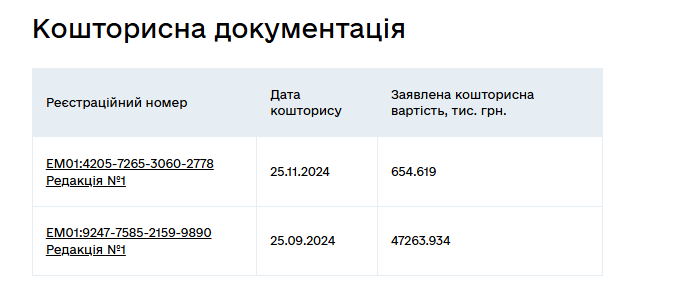

Дивна ситуація (EX01:9951-1936-5082-4435, EX01:3193-5155-1642-9686)

In [52]:
smallest_percentage_diff_df = h1_result[h1_result['cost_diff_pct']<-50].sort_values('cost_diff_pct', ascending=False).reset_index()
smallest_percentage_diff_df

registration_number_edessb    first_cost    last_cost  version_count  \
0    EX01:1603-5255-8481-5803    3747.92100   1810.03800              2   
1    EX01:3631-1888-6047-0410    3758.07900   1804.96600              2   
2    EX01:9884-0483-0863-5455    3141.00300   1479.30400              2   
3    EX01:5999-6056-8515-9050  137538.54800  64557.11100              4   
4    EX01:4825-8618-8677-2794   14743.51200   6450.95200              2   
5    EX01:0653-0121-0071-2120    1478.29069    519.99402              2   
6    EX01:8402-6615-5557-0166    2486.78800    801.04300              2   
7    EX01:6315-3429-6282-0226   59805.31200  17005.31200              4   
8    EX01:7104-9071-9912-1092    7800.54600   2107.50800              2   
9    EX01:5282-7173-6071-9034   30803.74700   4080.18800              3   
10   EX01:7650-7985-3138-0533   79191.64800   9747.76600              2   
11   EX01:3897-5514-2229-3223   48308.36300   1871.44300              2   
12   EX01:1006-4477-9249-0459   51585.31400    654.61900              3   

      cost_diff  cost_increased  cost_decreased  cost_diff_pct  
0   -1937.88300           False            True     -51.705546  
1   -1953.11300           False            True     -51.971047  
2   -1661.69900           False            True     -52.903452  
3  -72981.43700           False            True     -53.062533  
4   -8292.56000           False            True     -56.245486  
5    -958.29667           False            True     -64.824644  
6   -1685.74500           False            True     -67.788046  
7  -42800.00000           False            True     -71.565549  
8   -5693.03800           False            True     -72.982558  
9  -26723.55900           False            True     -86.754248  
10 -69443.88200           False            True     -87.690917  
11 -46436.92000           False            True     -96.126048  
12 -50930.69500           False            True     -98.730997

In [53]:
biggest_dif_df = h1_result[h1_result['cost_diff']>8000].sort_values('cost_diff', ascending=False).reset_index()

In [54]:
biggest_perc_dif_df['reason'] = 'Найбільший відсотковий зріст кошторису'
smallest_percentage_diff_df['reason'] = 'Найменший відсотковий спад кошторису'
biggest_dif_df['reason'] = 'Найбільший абсолютний зріст кошторису'

suspicious_df = pd.concat([
    biggest_perc_dif_df[['registration_number_edessb', 'reason']],
    smallest_percentage_diff_df[['registration_number_edessb', 'reason']],
    biggest_dif_df[['registration_number_edessb', 'reason']]
]).drop_duplicates()


suspicious_df.to_csv('suspicious_expertises_with_reason.csv', index=False)


#### 2) Expertise with multiple versions is more often associated with public funding.

In [55]:
# Aggregate by the number of versions per project
df_h2 = df[['registration_number_edessb', 'public_funding_involved', 'document_version']].drop_duplicates()

# Calculate the number of versions per project and public funding involvement
h2_result = (
    df_h2.groupby('registration_number_edessb')
    .agg(version_count=('document_version', 'nunique'),
         is_public=('public_funding_involved', 'max'))  # if public funding mentioned in at least one version
)

public_versions = h2_result[h2_result['is_public'] == 1]['version_count']
private_versions = h2_result[h2_result['is_public'] == 0]['version_count']

# Compare the average number of versions
avg_versions_public = public_versions.mean()
avg_versions_private = private_versions.mean()

print("\nH2: Average number of versions:")
print(f"🔹 With public funding: {avg_versions_public:.2f}")
print(f"🔸 Without public funding: {avg_versions_private:.2f}")

# Perform a t-test for independent samples
t_stat, p_value = ttest_ind(public_versions, private_versions, equal_var=False)

{
    "t_statistic": t_stat,
    "p_value": p_value,
    "avg_versions_public": public_versions.mean(),
    "avg_versions_private": private_versions.mean(),
    "n_public": len(public_versions),
    "n_private": len(private_versions)
}



H2: Average number of versions:
🔹 With public funding: 1.17
🔸 Without public funding: 1.42


{'t_statistic': np.float64(-29.55643402942392),
 'p_value': np.float64(1.025064695701951e-185),
 'avg_versions_public': np.float64(1.1711031948612942),
 'avg_versions_private': np.float64(1.4164396887159534),
 'n_public': 35651,
 'n_private': 10280}

Отже приватні замовники частіше мають проблеми з ПКД

#### 3) Changes in the number of stages or design stages between versions indicate project refinement/complication.

In [56]:
# 1. Aggregate information for each project
stages_variability = (
    raw_df.groupby('registration_number_edessb')
    .agg(
        num_versions=('document_version', 'nunique'),  # number of document versions
        unique_design_stages=('number_of_design_stages_int', 'nunique'),  # number of unique design stages (numeric)
        unique_current_stages=('current_design_stage', 'nunique'),        # number of unique current design stages (by name)
        first_design=('number_of_design_stages_int', 'first'),
        last_design=('number_of_design_stages_int', 'last'),
        first_stage=('current_design_stage', 'first'),
        last_stage=('current_design_stage', 'last'),
    )
    .reset_index()
)

# 2. Identify whether any changes occurred
stages_variability['design_changed'] = stages_variability['unique_design_stages'] > 1
stages_variability['stage_name_changed'] = stages_variability['unique_current_stages'] > 1

# 3. Filter only projects that have multiple versions
multi_version_projects = stages_variability[stages_variability['num_versions'] > 1]

# 4. Calculate the number and share of projects with changes
changed_projects = multi_version_projects[multi_version_projects['design_changed'] | multi_version_projects['stage_name_changed']]
changed_projects.reset_index()

changed_ratio = len(changed_projects) / len(multi_version_projects)
print(f"📊 Share of projects with DESIGN STAGE CHANGES among multi-version projects: {changed_ratio:.2%}")
print(f"📌 Number of such projects: {len(changed_projects)} out of {len(multi_version_projects)}")

# 5. Display the first 10 examples of projects with changes
print("\n🔍 Examples of projects with stage changes:")
display(changed_projects[['registration_number_edessb', 'num_versions', 'first_design', 'last_design', 'first_stage', 'last_stage']].head(10))

📊 Share of projects with DESIGN STAGE CHANGES among multi-version projects: 1.44%
📌 Number of such projects: 148 out of 10294

🔍 Examples of projects with stage changes:


registration_number_edessb  num_versions  first_design  last_design  \
269    EX01:0033-9192-2956-0026             2             2            1   
356    EX01:0046-6778-5760-0958             6             1            2   
655    EX01:0087-3240-3558-1325             3             1            2   
910    EX01:0124-3182-7953-4524             2             2            1   
1068   EX01:0143-7560-5639-7226             2             2            1   
1296   EX01:0172-7784-1296-7134             3             2            1   
1344   EX01:0180-4736-7630-1430             2             2            3   
1352   EX01:0181-7684-0315-8176             2             2            1   
1389   EX01:0186-4029-5808-3867             2             2            1   
1601   EX01:0214-9410-9510-1904             2             2            1   

              first_stage           last_stage  
269            проект (П)           проект (П)  
356   робочий проект (РП)  робочий проект (РП)  
655   робочий проект (РП)           проект (П)  
910            проект (П)           проект (П)  
1068  робочий проект (РП)  робочий проект (РП)  
1296           проект (П)  робочий проект (РП)  
1344           проект (П)           проект (П)  
1352           проект (П)           проект (П)  
1389           проект (П)           проект (П)  
1601           проект (П)           проект (П)

In [57]:
# Path to CSV
output_path = 'suspicious_expertises_with_reason.csv'

# 1. Load existing file (if it exists)
try:
    existing_df = pd.read_csv(output_path)
except FileNotFoundError:
    existing_df = pd.DataFrame()

# 2. Add a 'reason' column to changed_projects
changed_projects = changed_projects.copy()  # just in case, to avoid SettingWithCopyWarning
changed_projects['reason'] = (
    "Зміна стадій проектування: "
    "first_design = " + changed_projects['first_design'].astype(str) +
    ", last_design = " + changed_projects['last_design'].astype(str) +
    "; first_stage = " + changed_projects['first_stage'] +
    ", last_stage = " + changed_projects['last_stage']
)

# 3. Merge with existing data
updated_df = pd.concat([existing_df, changed_projects[['registration_number_edessb', 'reason']]], ignore_index=True)

# 4. Save
updated_df.to_csv(output_path, index=False)

#### 4) The number of changes (versions) depends on the type of construction or client. Breakdown by `construction_type` or `client_legal_status`.

In [58]:
# STEP 1: Calculate the number of versions per project
project_versions = raw_df.groupby('registration_number_edessb').agg(
    max_version=('document_version_int', 'max'),
    construction_type=('construction_type', 'first'),
    client_legal_status=('client_legal_status', 'first')
).reset_index()

# STEP 2: Aggregate by construction_type
agg_type = (
    project_versions
    .groupby('construction_type')
    .agg(
        avg_versions=('max_version', 'mean'),
        num_projects=('registration_number_edessb', 'count')
    )
    .sort_values('num_projects', ascending=False)
    .reset_index()
)

# STEP 3: Aggregate by client_legal_status
agg_client = (
    project_versions
    .groupby('client_legal_status')
    .agg(
        avg_versions=('max_version', 'mean'),
        num_projects=('registration_number_edessb', 'count')
    )
    .sort_values('num_projects', ascending=False)
    .reset_index()
)

# Output
print("🔧 Analysis by construction type:")
print(tabulate(agg_type, headers='keys', tablefmt='fancy_grid'))

print("\n🔧 Analysis by client's legal status:")
print(tabulate(agg_client, headers='keys', tablefmt='fancy_grid'))




🔧 Analysis by construction type:
╒════╤═════════════════════════════════════════════════════════╤════════════════╤════════════════╕
│    │ construction_type                                       │   avg_versions │   num_projects │
╞════╪═════════════════════════════════════════════════════════╪════════════════╪════════════════╡
│  0 │ Капітальний ремонт                                      │        1.13195 │          42258 │
├────┼─────────────────────────────────────────────────────────┼────────────────┼────────────────┤
│  1 │ Нове будівництво                                        │        1.44019 │          11763 │
├────┼─────────────────────────────────────────────────────────┼────────────────┼────────────────┤
│  2 │ Реконструкція                                           │        1.35961 │           6913 │
├────┼─────────────────────────────────────────────────────────┼────────────────┼────────────────┤
│  3 │ Реконструкція без зміни зовнішніх геометричних розмірів │        1.27

#### 5) There is a connection between the frequency of documentation changes and specific designers/experts.

In [59]:
# Group by registration number: calculate the number of versions for each object
version_counts = raw_df.groupby('registration_number_edessb')['document_version'].nunique().reset_index()
version_counts.columns = ['registration_number_edessb', 'num_versions']

# Merge with the main dataframe
df = raw_df.merge(version_counts, on='registration_number_edessb', how='left')

# Filtering and aggregation for design (project) organizations
proj_grouped = df.groupby('issuing_body_project_documentation')
proj_version_stats = proj_grouped.filter(lambda x: len(x) > 50)
proj_summary = (proj_version_stats
                .groupby('issuing_body_project_documentation')
                .agg(avg_versions=('num_versions', 'mean'),
                     count_expertise=('num_versions', 'count'))
                .reset_index()
                .sort_values(by='avg_versions', ascending=False)
                .head(10))

# Filtering and aggregation for expertise organizations
expert_grouped = df.groupby('issuing_body_expertise')
expert_version_stats = expert_grouped.filter(lambda x: len(x) > 50)
expert_summary = (expert_version_stats
                  .groupby('issuing_body_expertise')
                  .agg(avg_versions=('num_versions', 'mean'),
                       count_expertise=('num_versions', 'count'))
                  .reset_index()
                  .sort_values(by='avg_versions', ascending=False)
                  .head(10))

# Visualization — design organizations
fig1 = px.bar(
    proj_summary,
    x='avg_versions',
    y='issuing_body_project_documentation',
    orientation='h',
    title='Top-10 design organizations by average number of versions',
    hover_data=['count_expertise']
)
fig1.update_layout(yaxis_title='Organization name', xaxis_title='Average number of versions')
fig1.show()

# Visualization — expertise organizations
fig2 = px.bar(
    expert_summary,
    x='avg_versions',
    y='issuing_body_expertise',
    orientation='h',
    title='Top-10 expertise organizations by average number of versions',
    hover_data=['count_expertise']
)
fig2.update_layout(yaxis_title='Organization name', xaxis_title='Average number of versions')
fig2.show()



#### 6) Expertise organizations do NOT change between versions.

In [60]:
counts_expertise = raw_df.groupby('registration_number_edessb')['issuing_body_expertise'].nunique()

# Filter the results to include only those registration numbers where the count of unique 'issuing_body_expertise' is greater than 1.
# This identifies cases where multiple expertise organizations are associated with the same registration number.
counts_expertise[counts_expertise > 1]

Series([], Name: issuing_body_expertise, dtype: int64)

експертні організації з версіями не міняються

#### 7) Project organizations do NOT change between versions.

In [61]:
counts_expertise = raw_df.groupby('registration_number_edessb')['issuing_body_project_documentation'].nunique()

# Filter the results to include only those registration numbers where the count of unique 'issuing_body_expertise' is greater than 1.
# This identifies cases where multiple expertise organizations are associated with the same registration number.
counts_expertise[counts_expertise > 1].value_counts()

issuing_body_project_documentation
2    65
Name: count, dtype: int64

In [62]:
# Step 1: Sort by registration number and document version
raw_df_sorted = raw_df.sort_values(['registration_number_edessb', 'document_version_int'])

# Step 2: Find registration numbers where multiple project organizations were involved
counts_project_org = raw_df.groupby('registration_number_edessb')['issuing_body_project_documentation'].nunique()
multi_project_orgs = counts_project_org[counts_project_org > 1].index

# Step 3: Filter only those cases
filtered_df = raw_df_sorted[raw_df_sorted['registration_number_edessb'].isin(multi_project_orgs)].copy()

# Step 4: Add previous project organization
filtered_df.loc[:, 'prev_project_org'] = filtered_df.groupby('registration_number_edessb')['issuing_body_project_documentation'].shift()

# Step 5: Detect change
filtered_df.loc[:, 'project_org_changed'] = filtered_df['issuing_body_project_documentation'] != filtered_df['prev_project_org']

# Step 6: Keep only rows where the project organization changed
changes_df = filtered_df[filtered_df['project_org_changed']].copy()

# Step 7: Select key columns
result = changes_df[['registration_number_edessb',
                     'document_version_int',
                     'document_date',
                     'prev_project_org',
                     'issuing_body_project_documentation',
                     'issuing_body_expertise']].copy()

# Step 8: Add maximum document version per expertise
max_versions = raw_df.groupby('registration_number_edessb')['document_version_int'].max().rename('max_document_version')

# Step 9: Merge max versions into the result
result = result.merge(max_versions, on='registration_number_edessb', how='left')

# Step 11: Keep only the latest project change per registration_number_edessb
result = result.sort_values(['registration_number_edessb', 'document_version_int'], ascending=[True, False])

# Drop duplicates, keeping the one with the highest document version
result = result.drop_duplicates(subset='registration_number_edessb', keep='first')

# Reset index after dropping duplicates
result = result.reset_index(drop=True)

In [63]:
result.columns

Index(['registration_number_edessb', 'document_version_int', 'document_date',
       'prev_project_org', 'issuing_body_project_documentation',
       'issuing_body_expertise', 'max_document_version'],
      dtype='object')

In [64]:
# Group by (document_version_int, max_document_version) and count
pair_counts = result.groupby(['document_version_int', 'max_document_version']).size().reset_index(name='count')

# Sort by count descending
pair_counts = pair_counts.sort_values('count', ascending=False)
from tabulate import tabulate

# Display nicely with tabulate
print(tabulate(pair_counts, headers='keys', tablefmt='github', showindex=False))


|   document_version_int |   max_document_version |   count |
|------------------------|------------------------|---------|
|                      2 |                      2 |      31 |
|                      3 |                      3 |      10 |
|                      2 |                      3 |       9 |
|                      4 |                      4 |       5 |
|                      2 |                      4 |       3 |
|                      3 |                      4 |       3 |
|                      3 |                      5 |       2 |
|                      2 |                      5 |       1 |
|                      7 |                      7 |       1 |


In [65]:
last_lersion_changed_perc = round((result['document_version_int'] == result['max_document_version']).sum()/result.shape[0]*100, 2)
print(f'Відсоток експертиз, які поміняли проектанта перед останньою версією = {last_lersion_changed_perc}')

Відсоток експертиз, які поміняли проектанта перед останньою версією = 72.31


In [66]:
result['issuing_body_expertise'].value_counts(normalize=True).sort_values(ascending=False)[:3]

issuing_body_expertise
ТОВ "ЄВРОЕКСПЕРТИЗА"                               0.107692
ТОВ "ПЕРША БУДІВЕЛЬНА ЕКСПЕРТИЗА"                  0.076923
ТОВ "Українська будівельно-технічна експертиза"    0.061538
Name: proportion, dtype: float64

In [67]:
print('Організації, у яких забрали проект')
result['prev_project_org'].value_counts(normalize=True).sort_values(ascending=False)[:3]

Організації, у яких забрали проект


prev_project_org
ТОВ  ВИРОБНИЧЕ ПІДПРИЄМСТВО "ТЕПЛОГАЗБУД"    0.046154
ГОЛДОВСЬКИЙ ЮРІЙ ЯКОВИЧ                      0.046154
ЮЛІАННА КОБ'ЮК                               0.030769
Name: proportion, dtype: float64

In [68]:
print('Організації, яким віддали проект')
result['issuing_body_project_documentation'].value_counts(normalize=True).sort_values(ascending=False)[:3]

Організації, яким віддали проект


issuing_body_project_documentation
Смирнова Олена Георгіївна               0.046154
ТОВ ДОМУМ ГРУП                          0.030769
Приватне підприємство "ЖИТЛО "ПЛЮС""    0.030769
Name: proportion, dtype: float64

Аномалій не виявлено((

#### 8) Some expert organisation have little number of double-versions. They dont return suspicious projects

In [69]:
# Count how many unique registration numbers each project organization has
project_counts = raw_df.groupby('issuing_body_project_documentation')['registration_number_edessb'].nunique().rename('total_projects')

# Count how many projects per project organization have multiple versions
projects_multiple_versions = (
    raw_df.groupby(['issuing_body_project_documentation', 'registration_number_edessb'])
    .size()
    .reset_index(name='count_versions')
)

# Only projects with more than one version
projects_multiple_versions = projects_multiple_versions[projects_multiple_versions['count_versions'] > 1]

# Now count how many multi-version projects per project organisation
multi_version_projects_per_project_org = projects_multiple_versions.groupby('issuing_body_project_documentation').size().rename('multi_version_projects')

# Merge total and multi-version counts
project_summary = pd.concat([project_counts, multi_version_projects_per_project_org], axis=1).fillna(0)

# Calculate percentage
project_summary['multi_version_percentage'] = (project_summary['multi_version_projects'] / project_summary['total_projects']) * 100

# Filter project organisations with more than 50 projects
project_summary_filtered = project_summary[project_summary['total_projects'] > 50].sort_values('multi_version_percentage', ascending=False)


In [70]:
# Count how many unique registration numbers each expertise organisation has
expertise_counts = raw_df.groupby('issuing_body_expertise')['registration_number_edessb'].nunique().rename('total_projects')

# Count how many projects per expertise organisation have multiple versions
expertise_multiple_versions = (
    raw_df.groupby(['issuing_body_expertise', 'registration_number_edessb'])
    .size()
    .reset_index(name='count_versions')
)

# Only projects with more than one version
expertise_multiple_versions = expertise_multiple_versions[expertise_multiple_versions['count_versions'] > 1]

# Now count how many multi-version projects per expertise organisation
multi_version_projects_per_expertise = expertise_multiple_versions.groupby('issuing_body_expertise').size().rename('multi_version_projects')

# Merge total and multi-version counts
expertise_summary = pd.concat([expertise_counts, multi_version_projects_per_expertise], axis=1).fillna(0)

# Calculate percentage
expertise_summary['multi_version_percentage'] = (expertise_summary['multi_version_projects'] / expertise_summary['total_projects']) * 100

# Filter expertise organisations with more than 200 projects
expertise_summary_filtered = expertise_summary[expertise_summary['total_projects'] > 200].sort_values('multi_version_percentage', ascending=False)


In [71]:
# Histogram for project organisations
fig_project_hist = px.histogram(
    project_summary_filtered,
    x='multi_version_percentage',
    nbins=20,
    title='Distribution of Multi-Version Projects (%) among Project Organisations'
)
fig_project_hist.update_layout(
    xaxis_title='Multi-Version Projects (%)',
    yaxis_title='Number of Project Organisations',
    bargap=0.1
)
fig_project_hist.show()


In [72]:
# Histogram for expertise organisations
fig_expertise_hist = px.histogram(
    expertise_summary_filtered,
    x='multi_version_percentage',
    nbins=20,
    title='Distribution of Multi-Version Projects (%) among Expertise Organisations'
)
fig_expertise_hist.update_layout(
    xaxis_title='Multi-Version Projects (%)',
    yaxis_title='Number of Expertise Organisations',
    bargap=0.1
)
fig_expertise_hist.show()


In [73]:
# Bottom-5 expertise organisations
bottom_5_expertise = expertise_summary_filtered.sort_values('multi_version_percentage', ascending=True).head(5)

print("Bottom 5 Expertise Organisations (by Multi-Version %):")
print(tabulate(bottom_5_expertise.reset_index(), headers='keys', tablefmt='github', showindex=False))

Bottom 5 Expertise Organisations (by Multi-Version %):
| issuing_body_expertise                                                              |   total_projects |   multi_version_projects |   multi_version_percentage |
|-------------------------------------------------------------------------------------|------------------|--------------------------|----------------------------|
| ТОВ "ЕкспертБудКонсалт"                                                             |              820 |                       13 |                    1.58537 |
| ТОВ «Професійна будівельна експертиза»                                              |              449 |                       27 |                    6.01336 |
| КИЇВСЬКИЙ НАУКОВО-ДОСЛІДНИЙ ІНСТИТУТ СУДОВИХ ЕКСПЕРТИЗ МІНІСТЕРСТВА ЮСТИЦІЇ УКРАЇНИ |              821 |                       62 |                    7.55177 |
| Філія ДП "Укрдержбудекспертиза" у Волинській області                                |              658 |                       5

Варто звернути особливу увагу на ТОВ "ЕкспертБудКонсалт", адже % експертиз з кількома версіями у неї аномально низький, хоча кількість експертиз немаленька

## Analysis of organisation cooperation

##### Number of unique organisation

In [74]:
expert_organisations = raw_df['issuing_body_expertise'].nunique()
pjdoc_organisation = raw_df['issuing_body_project_documentation'].nunique()

print(f"Number of expertise organizations: {expert_organisations}")
print(f"Number of project organizations: {pjdoc_organisation}")



Number of expertise organizations: 107
Number of project organizations: 5967


In [75]:
# Take the latest version of each expertise
df_unique_expertise = raw_df.drop_duplicates(subset=['registration_number_edessb'], keep='last')

# Count rows where at least one of the specified columns has NaN
nan_count = df_unique_expertise[['issuing_body_expertise', 'issuing_body_project_documentation']].isna().any(axis=1).sum()

print(f"Number of rows with NaN in at least one of the columns: {nan_count}")

# Drop rows where both columns are NaN
df_unique_expertise = df_unique_expertise.dropna(subset=['issuing_body_expertise', 'issuing_body_project_documentation'])


Number of rows with NaN in at least one of the columns: 0


In [76]:
pair_occurrences = df_unique_expertise.groupby(
    ['issuing_body_project_documentation',
     'issuing_body_expertise']
).agg(
    pair_count=('doc_id', 'size'),
    total_cost=('declared_estimated_cost', 'sum')
).reset_index()

# Count the total number of expertises for each project documentation organization
total_expertises_per_documentation = df_unique_expertise.groupby(
    'issuing_body_project_documentation'
).size().reset_index(name='total_expertises')

# Count the total number of project documentations for each expertise organization
total_documents_per_expertise = df_unique_expertise.groupby(
    'issuing_body_expertise'
).size().reset_index(name='total_documents')

# Merge total counts with the pair occurrences
pair_occurrences = pair_occurrences.merge(
    total_expertises_per_documentation,
    on='issuing_body_project_documentation',
    how='left'
).merge(
    total_documents_per_expertise,
    on='issuing_body_expertise',
    how='left'
)

# Calculate the percentage of expertises relative to each project documentation organization
pair_occurrences['expertise_percentage_per_documentation'] = (
    pair_occurrences['pair_count'] / pair_occurrences['total_expertises'] * 100
).round(2)

# Calculate the percentage of project documentations relative to each expertise organization
pair_occurrences['documentation_percentage_per_expertise'] = (
    pair_occurrences['pair_count'] / pair_occurrences['total_documents'] * 100
).round(2)

# Sort the results by the number of occurrences in descending order
pair_occurrences = pair_occurrences.sort_values(
    by=['pair_count'],
    ascending=False
)


In [77]:
pair_occurrences

issuing_body_project_documentation  \
9276                          ТОВ "СКСВ ЛЕГІОН"   
9689                      ТОВ "УКРБУД ІНТЕГРАЛ"   
7028      ТОВ "БУДІВЕЛЬНА КОМПАНІЯ "МЕГА СТАЙЛ"   
8470                 ТОВ "НВП УКРЕКСПЕРТПРОЕКТ"   
4185   ПРИВАТНЕ ПІДПРИЄМСТВО "АВТОБАНБУДПРОЕКТ"   
...                                         ...   
11455               ЯКОВЕНКО ВІТАЛІЙ СЕРГІЙОВИЧ   
11457               ЯКОВЕНКО СЕРГІЙ МИКОЛАЙОВИЧ   
11489               ЯРОШИК В'ЯЧЕСЛАВ ВІКТОРОВИЧ   
11490               ЯРОШИК В'ЯЧЕСЛАВ ВІКТОРОВИЧ   
11494                      ЯЦИШИН ІГОР ІВАНОВИЧ   

                                  issuing_body_expertise  pair_count  \
9276                                ТОВ "ЕКСПЕРТИЗА МВК"         443   
9689                   ТОВ "ПЕРША БУДІВЕЛЬНА ЕКСПЕРТИЗА"         383   
7028                                ТОВ "ЕКСПЕРТИЗА МВК"         358   
8470                            ТОВ "УКРЕКСПЕРТИЗА ГРУП"         314   
4185                                ТОВ "ЕКСПЕРТИЗА МВК"         258   
...                                                  ...         ...   
11455                          ТОВ "ІНВЕСТ ЕКСПЕРТ ГРУП"           1   
11457  ДНІПРОВСЬКА ФІЛІЯ ДЕРЖАВНОГО ПІДПРИЄМСТВА "ДЕР...           1   
11489               ТОВ "КОНСАЛТИНГОВА АГЕНЦІЯ "ГАЛІЛЕО"           1   
11490                  ТОВ "ПЕРША БУДІВЕЛЬНА ЕКСПЕРТИЗА"           1   
11494                               ТОВ "ЄВРОЕКСПЕРТИЗА"           1   

         total_cost  total_expertises  total_documents  \
9276   3.010968e+06               449             7720   
9689   4.045556e+05               517             4247   
7028   4.231398e+05               378             7720   
8470   1.311372e+06               420             2215   
4185   6.372500e+05               259             7720   
...             ...               ...              ...   
11455  0.000000e+00                 3              173   
11457  0.000000e+00                 3              462   
11489  0.000000e+00                14              306   
11490  0.000000e+00                14             4247   
11494  8.010353e+04                92             2780   

       expertise_percentage_per_documentation  \
9276                                    98.66   
9689                                    74.08   
7028                                    94.71   
8470                                    74.76   
4185                                    99.61   
...                                       ...   
11455                                   33.33   
11457                                   33.33   
11489                                    7.14   
11490                                    7.14   
11494                                    1.09   

       documentation_percentage_per_expertise  
9276                                     5.74  
9689                                     9.02  
7028                                     4.64  
8470                                    14.18  
4185                                     3.34  
...                                       ...  
11455                                    0.58  
11457                                    0.22  
11489                                    0.33  
11490                                    0.02  
11494                                    0.04  

[11515 rows x 8 columns]

In [78]:
one_expertise = (total_expertises_per_documentation['total_expertises'] == 1).sum() / len(total_expertises_per_documentation) * 100
two_expertise = (total_expertises_per_documentation['total_expertises'] == 2).sum() / len(total_expertises_per_documentation) * 100
less_than_3_expertise = (total_expertises_per_documentation['total_expertises'] <= 3).sum() / len(total_expertises_per_documentation) * 100

print(f'Project documentation issuers with only one expertise in the registry: {round(one_expertise, 2)}%')
print(f'Project documentation issuers with two expertises in the registry: {round(two_expertise, 2)}%')
print(f'Project documentation issuers with 1–3 expertises: {round(less_than_3_expertise, 2)}%')

Project documentation issuers with only one expertise in the registry: 28.06%
Project documentation issuers with two expertises in the registry: 13.92%
Project documentation issuers with 1–3 expertises: 50.77%


In [79]:
pair_occurrences.groupby(
    'issuing_body_expertise'
).agg(
    total_expertises=('pair_count', 'sum'),
    max_percentage=('documentation_percentage_per_expertise', 'max'),
    unique_project_organisation=('issuing_body_project_documentation', 'nunique')
).sort_values(
    by='total_expertises',
    ascending=False
).reset_index().to_excel('top_expertise_organisations.xlsx',
            sheet_name='Sheet1', 
            index=False)

#### Different visualizations of project-expertise pairs

In [80]:
# Filter only the bottom 95% of values

threshold = total_expertises_per_documentation['total_expertises'].quantile(0.95)
filtered = total_expertises_per_documentation[total_expertises_per_documentation['total_expertises'] <= threshold]


fig = px.histogram(
    filtered,
    x = 'total_expertises'
)
fig.show()

In [81]:
# Сортуємо організації за кількістю експертиз
df_sorted = total_expertises_per_documentation.sort_values(
    by='total_expertises', ascending=False).reset_index(drop=True)

# Рахуємо кумулятивний % експертиз і % організацій
df_sorted['cumulative_expertises'] = df_sorted['total_expertises'].cumsum()
df_sorted['cumulative_expertises_percent'] = df_sorted['cumulative_expertises'] / df_sorted['total_expertises'].sum() * 100
df_sorted['organization_percent'] = (df_sorted.index + 1) / len(df_sorted) * 100
df_sorted['organization_count'] = df_sorted.index + 1

# Побудова графіку
fig = px.line(
    df_sorted,
    x='organization_percent',
    y='cumulative_expertises_percent',
    hover_data={
        'organization_percent': ':.2f',
        'cumulative_expertises_percent': ':.2f',
        'organization_count': True,
        'cumulative_expertises': True
    },
    labels={
        'organization_percent': '% проектних організацій',
        'cumulative_expertises_percent': '% усіх експертиз (кумулятивно)',
        'organization_count': 'Кількість організацій',
        'cumulative_expertises': 'К-сть експертиз'
    },
    title='Кумулятивне покриття експертиз проектними організаціями'
)

fig.update_traces(line=dict(width=4))

fig.update_layout(
    yaxis_range=[0, 100],
    xaxis_range=[0, 100],
    xaxis=dict(
        title='% проектних організацій',
        title_font=dict(size=18),
        tickfont=dict(size=16)
    ),
    yaxis=dict(
        title='% усіх експертиз (кумулятивно)',
        title_font=dict(size=18),
        tickfont=dict(size=16)
    )
)
fig.show()


In [82]:

# Групуємо по організаціях і public_funding_involved
grouped = raw_df.groupby(['issuing_body_project_documentation', 'public_funding_involved']) \
            .agg(total_expertises=('doc_id', 'count')) \
            .reset_index()

# Створимо порожній список для результатів
plot_data = []

# Робимо окремо для кожної групи (Так/Ні)
for funding_value, group in grouped.groupby('public_funding_involved'):
    df_sorted = group.sort_values(by='total_expertises', ascending=False).reset_index(drop=True)
    df_sorted['cumulative_expertises'] = df_sorted['total_expertises'].cumsum()
    df_sorted['cumulative_expertises_percent'] = df_sorted['cumulative_expertises'] / df_sorted['total_expertises'].sum() * 100
    df_sorted['organization_percent'] = (df_sorted.index + 1) / len(df_sorted) * 100
    df_sorted['organization_count'] = df_sorted.index + 1
    df_sorted['public_funding_involved'] = funding_value
    plot_data.append(df_sorted)

# Об'єднуємо
df_plot = pd.concat(plot_data)

# Побудова графіку
fig = px.line(
    df_plot,
    x='organization_percent',
    y='cumulative_expertises_percent',
    color='public_funding_involved',
    hover_data={
        'organization_percent': ':.2f',
        'cumulative_expertises_percent': ':.2f',
        'organization_count': True,
        'cumulative_expertises': True
    },
    labels={
        'organization_percent': '% проектних організацій',
        'cumulative_expertises_percent': '% експертиз (кумулятивно)',
        'organization_count': 'Кількість організацій',
        'cumulative_expertises': 'К-сть експертиз',
        'public_funding_involved': 'Бюджетне фінансування'
    },
    title='Покриття експертиз проектними організаціями (з бюджетним фінансуванням vs без)'
)

fig.update_layout(yaxis_range=[0, 100], xaxis_range=[0, 100])
fig.show()


In [83]:
total_expertises_per_documentation_with_year = df_unique_expertise.groupby(
    ['issuing_body_project_documentation', 'year']
).agg(
    total_expertises=('doc_id', 'size')
).reset_index()

# Фільтруємо 2025, якщо треба
df_filtered = total_expertises_per_documentation_with_year[
    total_expertises_per_documentation_with_year['year'] != 2025
]

# Порожній список для результатів
results = []

for year, df_year in df_filtered.groupby('year'):
    df_year_sorted = df_year.sort_values(by='total_expertises', ascending=False).reset_index(drop=True)
    df_year_sorted['cumulative_expertises'] = df_year_sorted['total_expertises'].cumsum()
    df_year_sorted['cumulative_expertises_percent'] = df_year_sorted['cumulative_expertises'] / df_year_sorted['total_expertises'].sum() * 100
    df_year_sorted['organization_percent'] = (df_year_sorted.index + 1) / len(df_year_sorted) * 100
    df_year_sorted['organization_count'] = df_year_sorted.index + 1
    df_year_sorted['total_orgs_in_year'] = len(df_year_sorted)
    df_year_sorted['year'] = year
    results.append(df_year_sorted)

df_plot = pd.concat(results)


# Побудова графіку
fig = px.line(
    df_plot,
    x='organization_percent',
    y='cumulative_expertises_percent',
    color='year',
    labels={
        'organization_percent': '% проектних організацій (ПКД)',
        'cumulative_expertises_percent': '% покриття експертиз (кумулятивно)',
        'year': 'Рік'
    },
    hover_data={
        'organization_count': True,
        'total_orgs_in_year': True,
        'organization_percent': ':.1f',
        'cumulative_expertises_percent': ':.1f'
    },
    title='Кумулятивне покриття експертиз проектними організаціями (по роках)'
)

fig.update_layout(yaxis_range=[0, 100], xaxis_range=[0, 100])
fig.show()


In [84]:
# Сортуємо організації за кількістю експертиз
df_sorted = total_documents_per_expertise.sort_values(
    by='total_documents', ascending=False).reset_index(drop=True)

# Рахуємо кумулятивний % експертиз і % організацій
df_sorted['cumulative_documents'] = df_sorted['total_documents'].cumsum()
df_sorted['cumulative_documents_percent'] = df_sorted['cumulative_documents'] / df_sorted['total_documents'].sum() * 100
df_sorted['organization_percent'] = (df_sorted.index + 1) / len(df_sorted) * 100
df_sorted['organization_count'] = df_sorted.index + 1

# Побудова графіку
fig = px.line(
    df_sorted,
    x='organization_percent',
    y='cumulative_documents_percent',
    hover_data={
        'organization_percent': ':.2f',
        'cumulative_documents_percent': ':.2f',
        'organization_count': True,
        'cumulative_documents': True
    },
    labels={
        'organization_percent': '% експертних організацій',
        'cumulative_documents_percent': '% усіх експертиз (кумулятивно)',
        'organization_count': 'Кількість організацій',
        'cumulative_documents': 'К-сть експертиз'
    },
    title='Кумулятивне покриття експертиз експертними організаціями'
)

fig.update_traces(line=dict(width=4))

fig.update_layout(
    yaxis_range=[0, 100],
    xaxis_range=[0, 100],
    xaxis=dict(
        title='% експертних організацій',
        title_font=dict(size=18),
        tickfont=dict(size=16)
    ),
    yaxis=dict(
        title='% усіх експертиз (кумулятивно)',
        title_font=dict(size=18),
        tickfont=dict(size=16)
    )
)

fig.show()


In [85]:
# Групуємо по організаціях і public_funding_involved
grouped = raw_df.groupby(['issuing_body_expertise', 'public_funding_involved']) \
            .agg(total_documents=('doc_id', 'count')) \
            .reset_index()

# Створимо порожній список для результатів
plot_data = []

# Робимо окремо для кожної групи (Так/Ні)
for funding_value, group in grouped.groupby('public_funding_involved'):
    df_sorted = group.sort_values(by='total_documents', ascending=False).reset_index(drop=True)
    df_sorted['cumulative_documents'] = df_sorted['total_documents'].cumsum()
    df_sorted['cumulative_documents_percent'] = df_sorted['cumulative_documents'] / df_sorted['total_documents'].sum() * 100
    df_sorted['organization_percent'] = (df_sorted.index + 1) / len(df_sorted) * 100
    df_sorted['organization_count'] = df_sorted.index + 1
    df_sorted['public_funding_involved'] = funding_value
    plot_data.append(df_sorted)

# Об'єднуємо
df_plot = pd.concat(plot_data)

# Побудова графіку
fig = px.line(
    df_plot,
    x='organization_percent',
    y='cumulative_documents_percent',
    color='public_funding_involved',
    hover_data={
        'organization_percent': ':.2f',
        'cumulative_documents_percent': ':.2f',
        'organization_count': True,
        'cumulative_documents': True
    },
    labels={
        'organization_percent': '% експертних організацій',
        'cumulative_documents_percent': '% експертиз (кумулятивно)',
        'organization_count': 'Кількість організацій',
        'cumulative_documents': 'К-сть експертиз',
        'public_funding_involved': 'Бюджетне фінансування'
    },
    title='Кумулятивне покриття експертиз експертними організаціями (з бюджетним фінансуванням та без)'
)

fig.update_layout(yaxis_range=[0, 100], xaxis_range=[0, 100])
fig.show()


In [86]:
# Припускаємо, у тебе є датафрейм: df_expertise з колонками ['issuing_body_expertise', 'total_documents', 'year']

df_expertise = df_unique_expertise.groupby(
    ['issuing_body_expertise', 'year']
).agg(
    total_documents=('doc_id', 'size')
).reset_index()


# Рахуємо графік для кожного року
all_years_plot_data = []
for year, group in df_expertise.groupby('year'):
    df_sorted = group.sort_values(by='total_documents', ascending=False).reset_index(drop=True)
    df_sorted['cumulative_documents'] = df_sorted['total_documents'].cumsum()
    df_sorted['cumulative_documents_percent'] = df_sorted['cumulative_documents'] / df_sorted['total_documents'].sum() * 100
    df_sorted['organization_percent'] = (df_sorted.index + 1) / len(df_sorted) * 100
    df_sorted['year'] = year
    df_sorted['organization_count'] = df_sorted.index + 1
    all_years_plot_data.append(df_sorted)

df_all_years = pd.concat(all_years_plot_data)
df_all_years['year'] = df_all_years['year'].astype(str)  # Виправлення типу

# Побудова графіку
fig = px.line(
    df_all_years,
    x='organization_percent',
    y='cumulative_documents_percent',
    color='year',
    hover_data={
        'organization_percent': ':.2f',
        'cumulative_documents_percent': ':.2f',
        'organization_count': True,
        'year': True
    },
    labels={
        'organization_percent': '% експертних організацій',
        'cumulative_documents_percent': '% покриття експертиз (кумулятивно)',
        'year': 'Рік'
    },
    title='Кумулятивне покриття експертиз експертними організаціями по роках'
)

fig.update_layout(yaxis_range=[0, 100], xaxis_range=[0, 100])
fig.show()



по роках різниці великої немає

20 топ організацій закривають 60% експертиз
20% проектних органіацій закривають 73% експертиз

#### Interdependence of expert and design organizations

In [87]:
fig = px.scatter(
    pair_occurrences,
    x='expertise_percentage_per_documentation',
    y='documentation_percentage_per_expertise',
    size='pair_count',
    color='total_cost',
    hover_data=['issuing_body_project_documentation', 'issuing_body_expertise'],
    title='Взаємозалежність експертних і проектних організацій'
)
fig.show()


In [88]:
suspicious_pairs = pair_occurrences[
    (pair_occurrences['expertise_percentage_per_documentation'] > 70) &
    (pair_occurrences['documentation_percentage_per_expertise'] > 5)
]
fig = px.scatter(
    suspicious_pairs,
    x='expertise_percentage_per_documentation',
    y='documentation_percentage_per_expertise',
    size='pair_count',
    color='total_cost',
    hover_data=['issuing_body_project_documentation', 'issuing_body_expertise'],
    title='Взаємозалежність експертних і проектних організацій'
)
fig.show()


#### Top "organisation pairs"

In [89]:
# Групуємо по проектній організації — для кожної знаходимо макс. експертизу %
max_partners = pair_occurrences.groupby('issuing_body_project_documentation')[
    'expertise_percentage_per_documentation'
].max().reset_index()

# Сортуємо по спадаючій, рахуємо кумулятивний % проектних організацій
max_partners = max_partners.sort_values(by='expertise_percentage_per_documentation', ascending=False).reset_index(drop=True)
max_partners['organization_percent'] = (max_partners.index + 1) / len(max_partners) * 100
max_partners['organization_count'] = max_partners.index + 1

# Побудова графіку
fig = px.line(
    max_partners,
    x='organization_percent',
    y='expertise_percentage_per_documentation',
    hover_data={
        'organization_percent': ':.2f',
        'expertise_percentage_per_documentation': ':.2f',
        'organization_count': True
    },
    labels={
        'organization_percent': '% проектних організацій',
        'expertise_percentage_per_documentation': '% експертиз, які здійснює один найчастіший експерт',
        'organization_count': 'Кількість організацій'
    },
    title='Залежність проектних організацій від найбільш частого експертного партнера'
)

fig.update_layout(yaxis_range=[0, 100], xaxis_range=[0, 100])
# Робимо лінію товстішою
fig.update_traces(line=dict(width=4))

# Оформлення графіка
fig.update_layout(

    yaxis_title='% експертиз,<br>які здійснює один найчастіший експерт'
)

fig.show()

In [90]:
# Групуємо по проектній організації — для кожної знаходимо макс. експертизу %
max_partners = pair_occurrences[pair_occurrences['pair_count']>50].groupby('issuing_body_project_documentation')[
    'expertise_percentage_per_documentation'
].max().reset_index()

# Сортуємо по спадаючій, рахуємо кумулятивний % проектних організацій
max_partners = max_partners.sort_values(by='expertise_percentage_per_documentation', ascending=False).reset_index(drop=True)
max_partners['organization_percent'] = (max_partners.index + 1) / len(max_partners) * 100
max_partners['organization_count'] = max_partners.index + 1

# Побудова графіку
fig = px.line(
    max_partners,
    x='organization_percent',
    y='expertise_percentage_per_documentation',
    hover_data={
        'organization_percent': ':.2f',
        'expertise_percentage_per_documentation': ':.2f',
        'organization_count': True
    },
    labels={
        'organization_percent': '% проектних організацій',
        'expertise_percentage_per_documentation': '% експертиз, які здійснює один найчастіший експерт',
        'organization_count': 'Кількість організацій'
    },
    title='Залежність проектних організацій від найбільш частого експертного партнера'
)

fig.update_layout(yaxis_range=[0, 100], xaxis_range=[0, 100])
# Робимо лінію товстішою
fig.update_traces(line=dict(width=4))


fig.show()


In [91]:
# Групуємо по експертній організації — шукаємо найбільшого партнера-проєктанта
max_clients = pair_occurrences.groupby('issuing_body_expertise')[
    'documentation_percentage_per_expertise'
].max().reset_index()

# Сортуємо за спаданням
max_clients = max_clients.sort_values(by='documentation_percentage_per_expertise', ascending=False).reset_index(drop=True)
max_clients['organization_percent'] = (max_clients.index + 1) / len(max_clients) * 100
max_clients['organization_count'] = max_clients.index + 1

# Побудова графіку
fig = px.line(
    max_clients,
    x='organization_percent',
    y='documentation_percentage_per_expertise',
    hover_data={
        'organization_percent': ':.2f',
        'documentation_percentage_per_expertise': ':.2f',
        'organization_count': True
    },
    labels={
        'organization_percent': '% експертних організацій',
        'documentation_percentage_per_expertise': '% проектної документації від найчастішого проєктанта',
        'organization_count': 'Кількість організацій'
    },
    title='Залежність експертних організацій від найбільш частого проєктного партнера'
)

fig.update_layout(yaxis_range=[0, 100], xaxis_range=[0, 100])
fig.update_traces(line=dict(width=4))

fig.show()


Why are there so many small project documentation developers?

#### Separately compare project organizations

In [129]:
top100_prj_organisation = df_unique_expertise.groupby(
    by='issuing_body_project_documentation'
    ).size().sort_values(
        ascending=False
    ).head(10)

In [130]:
def plot_expertise_partners_treemap(df, project_edrpou):
    # 1. Відібрати документи цього проектанта
    df_proj = df[df['issuing_body_project_documentation'] == project_edrpou].copy()

    # 2. Очистити назви організацій
    df_proj['project_org_clean'] = df_proj['issuing_body_project_documentation'].apply(clean_org_name)
    df_proj['expertise_org_clean'] = df_proj['issuing_body_expertise'].apply(clean_org_name)

    # 3. Мапа ЄДРПОУ → Назва експертної організації
    edrpou_name_map = df_proj[['issuing_body_expertise_edrpo', 'expertise_org_clean']] \
        .dropna().drop_duplicates().set_index('issuing_body_expertise_edrpo')['expertise_org_clean'].to_dict()

    # 4. Групування по експертним організаціям
    grouped = df_proj.groupby('issuing_body_expertise_edrpo').agg(
        total=('doc_id', 'count'),
        budget=('public_funding_involved', 'sum')
    ).reset_index()

    grouped['budget_share'] = round((grouped['budget'] / grouped['total']) * 100, 2)
    grouped['area_share'] = grouped['total'] / grouped['total'].sum() * 100
    grouped['expertise_name'] = grouped['issuing_body_expertise_edrpo'].map(edrpou_name_map)

    # 5. Додати рейтинг на ринку
    df['expertise_org_clean'] = df['issuing_body_expertise'].apply(clean_org_name)  # глобально
    total_by_expert_all = df.groupby('issuing_body_expertise_edrpo') \
        .size().sort_values(ascending=False).reset_index(name='total_all')
    total_by_expert_all['rank_all'] = total_by_expert_all['total_all'] \
        .rank(method='min', ascending=False).astype(int)

    grouped = grouped.merge(total_by_expert_all, on='issuing_body_expertise_edrpo', how='left')

    # 6. Заголовок
    total_docs = len(df_proj)
    overall_budget_percent = df_proj['public_funding_involved'].mean() * 100
    project_org_name = df_proj['project_org_clean'].dropna().unique()
    project_org_name = project_org_name[0] if len(project_org_name) > 0 else project_edrpou

    # 7. Побудова treemap
    fig = px.treemap(
        grouped,
        path=['expertise_name'],
        values='total',
        color='budget_share',
        color_continuous_scale='Plasma',
        range_color=[0, 100],
        custom_data=['total', 'budget_share', 'area_share', 'rank_all'],
        title=f"Експертні партнери проектанта <b>{project_org_name}</b> ({project_edrpou}) — "
              f"{total_docs} проектів з експертизами, {overall_budget_percent:.1f}% бюджетних"
    )

    fig.update_traces(
        hovertemplate=(
            '<b>%{label}</b><br>' +
            'К-сть спільних експертиз: %{customdata[0]}<br>' +
            '% бюджетних: %{customdata[1]:.2f}%<br>' +
            '% від площі: %{customdata[2]:.2f}%<br>' +
            'Місце на ринку: %{customdata[3]}<extra></extra>'
        )
    )

    return fig

def plot_expertise_collaboration(df_proj: pd.DataFrame) -> px.bar:
    """
    Створює графік динаміки співпраці з експертними організаціями за місяцями.

    Аргументи:
        df_proj: датафрейм з відфільтрованими записами для одного проектанта

    Повертає:
        Об'єкт fig (plotly bar chart)
    """
    total_doc = len(df_proj)

    # Словник мапінгу
    edrpou_to_name = df_proj.set_index('issuing_body_expertise_edrpo')['issuing_body_expertise'].to_dict()
    edrpou_to_name = {k: clean_org_name(v) for k, v in edrpou_to_name.items() if pd.notnull(k) and pd.notnull(v)}

    # Агрегація
    df_time = df_proj.groupby([
        'year_month',
        'issuing_body_expertise_edrpo'
    ]).size().reset_index(name='count')

    df_time['year_month'] = df_time['year_month'].dt.to_timestamp()
    df_time['expertise_org_name'] = df_time['issuing_body_expertise_edrpo'].map(edrpou_to_name)

    # Гарантуємо повний діапазон по осі X
    full_range = pd.date_range('2021-01-01', '2025-04-01', freq='MS')  # MS = Month Start
    orgs = df_time['expertise_org_name'].dropna().unique()

    df_complete = (
        pd.MultiIndex.from_product([full_range, orgs], names=['year_month', 'expertise_org_name'])
        .to_frame(index=False)
        .merge(df_time[['year_month', 'expertise_org_name', 'count']], on=['year_month', 'expertise_org_name'], how='left')
        .fillna({'count': 0})
    )

    # Побудова графіка
    fig = px.bar(
        df_complete,
        x='year_month',
        y='count',
        color='expertise_org_name',
        title=f'Динаміка співпраці з експертними організаціями. К-ть експертиз: {total_doc}',
        labels={
            'year_month': 'Місяць',
            'count': 'К-сть спільних експертиз',
            'expertise_org_name': 'Експертна організація'
        }
    )

    # Фіксуємо вісь
    fig.update_xaxes(range=['2021-01-01', '2025-04-01'])

    # Оформлення графіка
    fig.update_layout(
        title=None,         # Прибрати заголовок
        showlegend=False,   # Прибрати легенду
        xaxis=dict(
            title='Місяць',
            title_font=dict(size=18),   # Розмір заголовку осі X
            tickfont=dict(size=14)      # Розмір підписів осі X
        ),
        yaxis=dict(
            title='К-сть спільних експертиз',
            title_font=dict(size=18),   # Розмір заголовку осі Y
            tickfont=dict(size=14)      # Розмір підписів осі Y
        )
    )
    return fig

def analyze_projectant(df_full, project_edrpou):
    # 1. Відібрати всі документи цього проектанта
    df_proj = df_full[df_full['issuing_body_project_documentation'] == project_edrpou].copy()

    # 2. Treemap: експертні організації + бюджетність
    fig_treemap = plot_expertise_partners_treemap(df_full, project_edrpou)
    
    # 3. Відсоток бюджетних проектів
    budget_percent_proj = df_proj['public_funding_involved'].mean() * 100
    budget_percent_all = df_full['public_funding_involved'].mean() * 100

    # 4. Середнє число версій документа
    avg_versions_proj = df_proj['document_version_int'].astype(float).mean()
    avg_versions_all = df_full['document_version_int'].astype(float).mean()

    # 5. Середнє число стадій проектування
    avg_stages_proj = df_proj['number_of_design_stages_int'].astype(float).mean()
    avg_stages_all = df_full['number_of_design_stages_int'].astype(float).mean()

    # 6. Розподіл типів будівництва
    constr_type_proj = df_proj['construction_type'].value_counts(normalize=True) * 100
    constr_type_all = df_full['construction_type'].value_counts(normalize=True) * 100
    constr_compare = pd.DataFrame({
        'projectant': constr_type_proj,
        'all': constr_type_all
    }).fillna(0).reset_index().rename(columns={'index': 'construction_type'})

    # 7. Динаміка співпраці з експертами по місяцях
    fig_line = plot_expertise_collaboration(df_proj)

    # 8. Повернути всі результати
    return {
        "fig_treemap": fig_treemap,
        "budget_percent_proj": budget_percent_proj,
        "budget_percent_all": budget_percent_all,
        "avg_versions_proj": avg_versions_proj,
        "avg_versions_all": avg_versions_all,
        "avg_stages_proj": avg_stages_proj,
        "avg_stages_all": avg_stages_all,
        "construction_comparison": constr_compare,
        "fig_line": fig_line
    }


In [131]:
for pj_org in top100_prj_organisation.index:
    result = analyze_projectant(df_unique_expertise, pj_org)
    result['fig_treemap'].show()
    result['fig_line'].show()

#     # Вивести метрики з форматуванням
#     print(f"📊 Всього експертиз: {result['fig_treemap'].layout.title.text.split('—')[1].strip()}")
    # print(f"🏗️  Бюджетні проєкти у проектанта: {result['budget_percent_proj']:.2f}%")
    # print(f"🏛️  Бюджетні проєкти по ринку:      {result['budget_percent_all']:.2f}%")
#     print()
#     print(f"📄 Середня кількість версій у проектанта: {result['avg_versions_proj']:.2f}")
#     print(f"📄 Середня кількість версій по ринку:     {result['avg_versions_all']:.2f}")
#     print()
#     print(f"📐 Середня кількість стадій у проектанта: {result['avg_stages_proj']:.2f}")
#     print(f"📐 Середня кількість стадій по ринку:     {result['avg_stages_all']:.2f}")


    # print("\n🏗️ Розподіл типів будівництва (%):")
    # display(result['construction_comparison'].style
    # .format({'projectant': '{:.1f}%', 'all': '{:.1f}%'})
    # .set_properties(**{'text-align': 'center'})
    # .set_table_styles([dict(selector='th', props=[('text-align', 'center')])]))


#### Separately compare expertise organizations

In [97]:
def plot_project_partners_treemap(df, expertise_edrpou):
    df_exp = df[df['issuing_body_expertise_edrpo'] == expertise_edrpou].copy()

    df_exp['expertise_org_clean'] = df_exp['issuing_body_expertise'].apply(clean_org_name)
    df_exp['project_org_clean'] = df_exp['issuing_body_project_documentation'].apply(clean_org_name)

    edrpou_name_map = df_exp[['issuing_body_project_documentation_edrpo', 'project_org_clean']] \
        .dropna().drop_duplicates().set_index('issuing_body_project_documentation_edrpo')['project_org_clean'].to_dict()

    grouped = df_exp.groupby('issuing_body_project_documentation_edrpo').agg(
        total=('doc_id', 'count'),
        budget=('public_funding_involved', 'sum')
    ).reset_index()

    grouped['budget_share'] = round((grouped['budget'] / grouped['total']) * 100, 2)
    grouped['area_share'] = grouped['total'] / grouped['total'].sum() * 100
    grouped['project_name'] = grouped['issuing_body_project_documentation_edrpo'].map(edrpou_name_map)

    df['project_org_clean'] = df['issuing_body_project_documentation'].apply(clean_org_name)
    total_by_proj_all = df.groupby('issuing_body_project_documentation_edrpo') \
        .size().sort_values(ascending=False).reset_index(name='total_all')
    total_by_proj_all['rank_all'] = total_by_proj_all['total_all'] \
        .rank(method='min', ascending=False).astype(int)

    grouped = grouped.merge(total_by_proj_all, on='issuing_body_project_documentation_edrpo', how='left')

    total_docs = len(df_exp)
    overall_budget_percent = df_exp['public_funding_involved'].mean() * 100
    expertise_org_name = df_exp['expertise_org_clean'].dropna().unique()
    expertise_org_name = expertise_org_name[0] if len(expertise_org_name) > 0 else expertise_edrpou

    fig = px.treemap(
        grouped,
        path=['project_name'],
        values='total',
        color='budget_share',
        color_continuous_scale='Plasma',
        range_color=[0, 100],
        custom_data=['total', 'budget_share', 'area_share', 'rank_all'],
        title=f"Проектні партнери експертної організації <b>{expertise_org_name}</b> ({expertise_edrpou}) — "
              f"{total_docs} експертиз, {overall_budget_percent:.1f}% бюджетних"
    )

    fig.update_traces(
        hovertemplate=(
            '<b>%{label}</b><br>' +
            'К-сть спільних експертиз: %{customdata[0]}<br>' +
            '% бюджетних: %{customdata[1]:.2f}%<br>' +
            '% від площі: %{customdata[2]:.2f}%<br>' +
            'Місце на ринку: %{customdata[3]}<extra></extra>'
        )
    )

    return fig

def plot_project_collaboration(df_exp: pd.DataFrame) -> px.bar:
    total_doc = len(df_exp)

    edrpou_to_name = df_exp.set_index('issuing_body_project_documentation_edrpo')['issuing_body_project_documentation'].to_dict()
    edrpou_to_name = {k: clean_org_name(v) for k, v in edrpou_to_name.items() if pd.notnull(k) and pd.notnull(v)}

    df_time = df_exp.groupby([
        'year_month',
        'issuing_body_project_documentation_edrpo'
    ]).size().reset_index(name='count')

    df_time['year_month'] = df_time['year_month'].dt.to_timestamp()
    df_time['project_org_name'] = df_time['issuing_body_project_documentation_edrpo'].map(edrpou_to_name)

    full_range = pd.date_range('2021-01-01', '2025-04-01', freq='MS')
    orgs = df_time['project_org_name'].dropna().unique()

    df_complete = (
        pd.MultiIndex.from_product([full_range, orgs], names=['year_month', 'project_org_name'])
        .to_frame(index=False)
        .merge(df_time[['year_month', 'project_org_name', 'count']], on=['year_month', 'project_org_name'], how='left')
        .fillna({'count': 0})
    )

    fig = px.bar(
        df_complete,
        x='year_month',
        y='count',
        color='project_org_name',
        title=f'Динаміка співпраці з проектантами. К-ть експертиз: {total_doc}',
        labels={
            'year_month': 'Місяць',
            'count': 'К-сть спільних експертиз',
            'project_org_name': 'Проектна організація'
        }
    )

    fig.update_xaxes(range=['2021-01-01', '2025-04-01'])

    return fig

def analyze_expertise(df_full, expertise_edrpou):
    df_exp = df_full[df_full['issuing_body_expertise_edrpo'] == expertise_edrpou].copy()

    fig_treemap = plot_project_partners_treemap(df_full, expertise_edrpou)

    budget_percent_proj = df_exp['public_funding_involved'].mean() * 100
    budget_percent_all = df_full['public_funding_involved'].mean() * 100

    avg_versions_proj = df_exp['document_version_int'].astype(float).mean()
    avg_versions_all = df_full['document_version_int'].astype(float).mean()

    avg_stages_proj = df_exp['number_of_design_stages_int'].astype(float).mean()
    avg_stages_all = df_full['number_of_design_stages_int'].astype(float).mean()

    constr_type_proj = df_exp['construction_type'].value_counts(normalize=True) * 100
    constr_type_all = df_full['construction_type'].value_counts(normalize=True) * 100
    constr_compare = pd.DataFrame({
        'expertise_org': constr_type_proj,
        'all': constr_type_all
    }).fillna(0).reset_index().rename(columns={'index': 'construction_type'})

    fig_line = plot_project_collaboration(df_exp)

    return {
        "fig_treemap": fig_treemap,
        "budget_percent_proj": budget_percent_proj,
        "budget_percent_all": budget_percent_all,
        "avg_versions_proj": avg_versions_proj,
        "avg_versions_all": avg_versions_all,
        "avg_stages_proj": avg_stages_proj,
        "avg_stages_all": avg_stages_all,
        "construction_comparison": constr_compare,
        "fig_line": fig_line
    }


In [132]:
top10_exp_organisation = df_unique_expertise.groupby(
    by='issuing_body_expertise_edrpo'
    ).size().sort_values(
        ascending=False
    ).head(1)

In [133]:
for pj_org in top10_exp_organisation.index:
    result = analyze_expertise(df_unique_expertise, pj_org)
    result['fig_treemap'].show()
    result['fig_line'].show()

#     # Вивести метрики з форматуванням
#     print(f"📊 Всього експертиз: {result['fig_treemap'].layout.title.text.split('—')[1].strip()}")
#     print(f"🏗️  Бюджетні проєкти у проектанта: {result['budget_percent_proj']:.2f}%")
#     print(f"🏛️  Бюджетні проєкти по ринку:      {result['budget_percent_all']:.2f}%")
#     print()
#     print(f"📄 Середня кількість версій у проектанта: {result['avg_versions_proj']:.2f}")
#     print(f"📄 Середня кількість версій по ринку:     {result['avg_versions_all']:.2f}")
#     print()
#     print(f"📐 Середня кількість стадій у проектанта: {result['avg_stages_proj']:.2f}")
#     print(f"📐 Середня кількість стадій по ринку:     {result['avg_stages_all']:.2f}")


    # print("\n🏗️ Розподіл типів будівництва (%):")
    # display(result['construction_comparison'].style
    # .format({'projectant': '{:.1f}%', 'all': '{:.1f}%'})
    # .set_properties(**{'text-align': 'center'})
    # .set_table_styles([dict(selector='th', props=[('text-align', 'center')])]))


## Specialization of Expertise Organizations

Hypothesis: Each expertise organization focuses on 1–2 types of expertise.
Goal: Identify the distribution of specialization — are there “omnivorous” experts or, conversely, narrow professionals?

### Preparing the DataFrame

In [101]:
all_areas = raw_df['expertise_area'].dropna().astype(str)
unique_areas = set()
for row in all_areas:
    areas = [a.strip() for a in row.split(",") if a.strip().startswith(
        ("З питань", "Архітектурн", "Конструктивні", "Розділ"))]
    unique_areas.update(areas)

In [102]:
known_starts = ("З питань", "Архітектур", "Конструктивн", "Розділ", "Щодо об’єктів")

def split_areas(text):
    if pd.isna(text): return []
    parts = [p.strip() for p in re.split(r',(?![^()]*\))', text)]
    areas, current = [], ""
    for part in parts:
        if part.startswith(known_starts):
            if current: areas.append(current)
            current = part
        else:
            current += "_" + part
    if current: areas.append(current)
    return [a.strip() for a in areas]

df_unique_expertise['parsed_areas'] = df_unique_expertise['expertise_area'].apply(split_areas)

# Булевий датафрейм
unique_areas = sorted(set(a for lst in df_unique_expertise['parsed_areas'] for a in lst))
area_df = pd.DataFrame([
    {area: area in lst for area in unique_areas}
    for lst in df_unique_expertise['parsed_areas']
])

In [103]:
# Приводимо індекси до однакового вигляду
area_df.index = df_unique_expertise.index

# Обʼєднуємо датафрейми
combined_df = pd.concat([df_unique_expertise, area_df], axis=1)
combined_df['n_areas'] = area_df.sum(axis=1)

### Analysis by Expertise Organizations

In [104]:
area_counts = combined_df[area_df.columns].sum().sort_values(ascending=False)
area_counts

З питань кошторисної частини проектної документації                                                              52863
З питань міцності_надійності_довговічності                                                                       31011
З питань пожежної безпеки                                                                                        19966
З питань охорони праці                                                                                           17600
З питань санітарного і епідеміологічного благополуччя населення                                                  17362
З питань енергозбереження                                                                                        17025
З питань експлуатаційної безпеки                                                                                 16167
З питань екології                                                                                                15915
З питань створення умов для безперешкодного дост

In [105]:
melted = combined_df.melt(
    id_vars=['issuing_body_expertise'],
    value_vars=area_df.columns,
    var_name='expertise_area',
    value_name='has_area'
)
filtered = melted[melted['has_area']]

area_counts_per_org = (
    filtered.groupby(['issuing_body_expertise', 'expertise_area'])
    .size()
    .reset_index(name='n_expertises')
)

# Залишаємо лише ті, де > 20 експертизи по напрямку
significant = area_counts_per_org[area_counts_per_org['n_expertises'] > 5]

n_areas_per_org = (
    significant.groupby('issuing_body_expertise')['expertise_area']
    .nunique()
    .reset_index(name='n_strong_areas')
)

fig = px.histogram(
    n_areas_per_org,
    x='n_strong_areas',
    title='Кількість напрямів, які експертна організація реально покриває (>5 експертизи)',
    labels={'n_strong_areas': 'Кількість напрямів'},
)

fig.update_layout(bargap=0.2)


fig.show()

In [106]:
# 1. Спочатку залишаємо організації з 1 або 2 напрямками
orgs_with_few_areas = n_areas_per_org[n_areas_per_org['n_strong_areas'] < 5]

# 2. Тепер фільтруємо основну таблицю significant тільки для цих організацій
few_areas_detail = significant[significant['issuing_body_expertise'].isin(orgs_with_few_areas['issuing_body_expertise'])]

# 3. Виводимо
few_areas_detail = few_areas_detail.sort_values(['issuing_body_expertise', 'expertise_area']).reset_index(drop=True)

few_areas_detail


issuing_body_expertise  \
0                                 КП "Київекспертиза"   
1   Київська обласна  філія  ДП  "НДІпроектреконст...   
2   НАЦІОНАЛЬНИЙ НАУКОВИЙ ЦЕНТР «ІНСТИТУТ СУДОВИХ ...   
3                              ПП "Бердянськміськбуд"   
4                                ТОВ "ІСБ-ЕКСПЕРТИЗА"   
5                              ТОВ "ЕК УКРБУДЕКСПЕРТ"   
6                  ТОВ "ОФІС ПРОЕКТІВ МІСТОБУДУВАННЯ"   
7                  ТОВ "ОФІС ПРОЕКТІВ МІСТОБУДУВАННЯ"   
8            ТОВ "ПЕРШИЙ ЦЕНТР БУДІВЕЛЬНИХ ЕКСПЕРТИЗ"   
9                                   ТОВ "ПРОСПЕР КБЗ"   
10             ТОВ "ЦЕНТРАЛЬНА БУДІВЕЛЬНА ЕКСПЕРТИЗА"   
11             ТОВ "ЦЕНТРАЛЬНА БУДІВЕЛЬНА ЕКСПЕРТИЗА"   
12             ТОВ «Професійна будівельна експертиза»   
13  Філія "ЖИТОМИРКОМУН ДОРПРОЕКТ"  ДП  "НДІпроект...   
14  Філія ДП "Укрдержбудекспертиза"  у Чернігівськ...   
15  філія ДП "Укрдержбудекспертиза"-"Укрдордержбуд...   

                                       expertise_area  n_expertises  
0   З питань кошторисної частини проектної докумен...           175  
1   З питань кошторисної частини проектної докумен...           186  
2   З питань кошторисної частини проектної докумен...            38  
3   З питань кошторисної частини проектної докумен...            34  
4   З питань кошторисної частини проектної докумен...             8  
5          З питань міцності_надійності_довговічності            12  
6   З питань кошторисної частини проектної докумен...             8  
7          З питань міцності_надійності_довговічності             6  
8   З питань кошторисної частини проектної докумен...            11  
9   З питань кошторисної частини проектної докумен...           149  
10  З питань кошторисної частини проектної докумен...            34  
11         З питань міцності_надійності_довговічності            10  
12  З питань кошторисної частини проектної докумен...           449  
13  З питань кошторисної частини проектної докумен...            15  
14  З питань кошторисної частини проектної докумен...            26  
15  З питань кошторисної частини проектної докумен...           176

In [107]:
# 1. Melt: кожен рядок — напрямок в одній експертизі
melted = combined_df.drop_duplicates(
    'registration_number_edessb',
    keep='first')\
.melt(
    id_vars=['issuing_body_expertise'],
    value_vars=area_df.columns,
    var_name='area',
    value_name='has_area'
)
# 2. Залишаємо тільки ті, де напрямок був присутній
filtered = melted[melted['has_area']]

# 3. Рахуємо: скільки експертиз по кожній (org × area)
area_org_counts = (
    filtered.groupby(['area', 'issuing_body_expertise'])
    .size()
    .reset_index(name='count')
)

# 4. Знаходимо максимум для кожного напрямку
top_by_area = area_org_counts.sort_values(['area', 'count'], ascending=[True, False])
top_orgs = top_by_area.groupby('area').first().reset_index()

# 5. Додаємо загальну кількість експертиз по кожному напрямку
total_per_area = filtered['area'].value_counts().rename_axis('area').reset_index(name='total')
top_orgs = top_orgs.merge(total_per_area, on='area')
top_orgs
# 6. Рахуємо частку
top_orgs['share_pct'] = (top_orgs['count'] / top_orgs['total'] * 100).round(1)
top_orgs
# 7. Вивід
top_orgs = top_orgs.rename(columns={
    'area': 'Напрям',
    'issuing_body_expertise': 'ТОП організація',
    'count': 'Кількість експертиз ТОП організації',
    'total': 'Загальна кількість експертиз',
    'share_pct': 'Частка, %'
})

top_orgs.sort_values('Загальна кількість експертиз', ascending=False, inplace=True)
top_orgs

Напрям  \
8   З питань кошторисної частини проектної докумен...   
9          З питань міцності_надійності_довговічності   
11                          З питань пожежної безпеки   
10                             З питань охорони праці   
12  З питань санітарного і епідеміологічного благо...   
7                           З питань енергозбереження   
6                    З питань експлуатаційної безпеки   
4                                   З питань екології   
13  З питань створення умов для безперешкодного до...   
16                  З питань інженерного забезпечення   
14                       З питань техногенної безпеки   
2   З питань  інженерно-технічних  заходів  цивіль...   
1                    Архітектурно-планувальні рішення   
0                   Архітектурне об'ємне проектування   
3                                З питань архітектури   
26  Щодо об’єктів_які споруджуються із залученням ...   
5    З питань експертизи проектної документації доріг   
25                     Розділ організація будівництва   
22      Розділ електрообладнання та електроосвітлення   
21                            Розділ генеральний план   
19            Розділ водопостачання та водовідведення   
24  Розділ опалення_вентиляція та кондиціонування ...   
17  Конструктивні рішення зовнішніх мереж та інжен...   
23                     Розділ зв'язок та сигналізація   
18        Розділ автоматизація інженерного обладнання   
20                   Розділ газо- та холодопостачання   
15            З питань ядерної та радіаційної безпеки   

                                      ТОП організація  \
8                                ТОВ "ЕКСПЕРТИЗА МВК"   
9                                ТОВ "ЄВРОЕКСПЕРТИЗА"   
11                  ТОВ "ПЕРША БУДІВЕЛЬНА ЕКСПЕРТИЗА"   
10                                ТОВ "УК ЕКСПЕРТИЗА"   
12                  ТОВ "ПЕРША БУДІВЕЛЬНА ЕКСПЕРТИЗА"   
7                   ТОВ "ПЕРША БУДІВЕЛЬНА ЕКСПЕРТИЗА"   
6                                 ТОВ "УК ЕКСПЕРТИЗА"   
4                                 ТОВ "УК ЕКСПЕРТИЗА"   
13                                ТОВ "УК ЕКСПЕРТИЗА"   
16                                ТОВ "УК ЕКСПЕРТИЗА"   
14                  ТОВ "ПЕРША БУДІВЕЛЬНА ЕКСПЕРТИЗА"   
2                                 ТОВ "УК ЕКСПЕРТИЗА"   
1                                ТОВ "ЄВРОЕКСПЕРТИЗА"   
0                                 ТОВ "УК ЕКСПЕРТИЗА"   
3                            ТОВ "УКРЕКСПЕРТИЗА ГРУП"   
26                                ТОВ "УК ЕКСПЕРТИЗА"   
5                            ТОВ "УКРЕКСПЕРТИЗА ГРУП"   
25                                ТОВ "УК ЕКСПЕРТИЗА"   
22                          ТОВ "ЕКСПЕРТ ПРОЕКТ ГРУП"   
21                                ТОВ "УК ЕКСПЕРТИЗА"   
19                          ТОВ "ЕКСПЕРТ ПРОЕКТ ГРУП"   
24  ТОВ "Інститут експертно-технічних рішень у буд...   
17  Вінницька обласна комунальна установа "Служба ...   
23  ТОВ "Інститут експертно-технічних рішень у буд...   
18  ТОВ "Інститут експертно-технічних рішень у буд...   
20  ТОВ "Інститут експертно-технічних рішень у буд...   
15                          ДП "Укрдержбудекспертиза"   

    Кількість експертиз ТОП організації  Загальна кількість експертиз  \
8                                  7206                         52863   
9                                  2009                         31011   
11                                 1243                         19966   
10                                 1192                         17600   
12                                 1229                         17362   
7                                  1183                         17025   
6                                  1339                         16167   
4                                  1215                         15915   
13                                 1120                         14016   
16                                 1191                         13902   
14                                 1231           

In [108]:
top_orgs['Напрям'].nunique()

27

In [109]:
top_orgs.to_csv('expertise_area.csv', sep=';')

In [134]:
# 1. Melt, як і раніше
melted = combined_df.melt(
    id_vars=['issuing_body_expertise', 'year_month'],
    value_vars=area_df.columns,
    var_name='area',
    value_name='has_area'
)

# 2. Фільтруємо лише експертизи з напрямками
filtered = melted[melted['has_area']]

# 4. Визначаємо топ-напрямки (де >1000 експертиз)
top_areas = top_orgs[(top_orgs['Загальна кількість експертиз'] > 4000)]['Напрям']

# 5. Фільтруємо тільки ці напрямки
filtered_top = filtered[filtered['area'].isin(top_areas)]
top_areas

# 6. Групуємо: напрям × дата × організація
grouped = (
    filtered_top
    .groupby(['area', 'year_month', 'issuing_body_expertise'])
    .size()
    .reset_index(name='n_expertises')
)

# 6. Додаємо total експертиз по кожному (area, year_month)
total_per_month = (
    grouped
    .groupby(['area', 'year_month'])['n_expertises']
    .sum()
    .reset_index(name='total_expertises')
)

# 7. Merge — рахуємо відсоток
merged = grouped.merge(total_per_month, on=['area', 'year_month'])
merged['pct'] = (merged['n_expertises'] / merged['total_expertises'] * 100)

# 8. Фільтруємо тільки де > 15%
merged = merged[merged['pct'] > 15]


# 9. Перетворюємо Period на рядок для Plotly
merged['year_month'] = merged['year_month'].dt.to_timestamp()

# Визначаємо фіксовану вісь X
x_start = pd.Timestamp('2021-01-01')
x_end = pd.Timestamp('2024-12-31')

# 10. Барчарт по кожному напрямку з лінією кількості експертиз напрямку щомісяця
for area in top_areas:
    df_area = merged[merged['area'] == area]
    if df_area.empty:
        continue

    # Побудова stacked bar тільки для тих, хто >15%
    df_plot = df_area[df_area['pct'] > 15]

    # Побудова total_expertises для всіх місяців
    total_line = (
        grouped[grouped['area'] == area]
        .groupby('year_month')['n_expertises']
        .sum()
        .reset_index(name='total_expertises')
        .sort_values('year_month')
    )

    if isinstance(df_plot['year_month'].dtype, pd.PeriodDtype):
        df_plot['year_month'] = df_plot['year_month'].dt.to_timestamp()

    if isinstance(total_line['year_month'].dtype, pd.PeriodDtype):
        total_line['year_month'] = total_line['year_month'].dt.to_timestamp()


    fig = px.bar(
        df_plot,
        x='year_month',
        y='pct',
        color='issuing_body_expertise',
        title=f"ТОП організації у напрямку: {area} (де частка >15%)",
        labels={
            'pct': 'Частка експертиз у місяці',
            'year_month': 'Місяць',
            'issuing_body_expertise': 'Експертна організація'
        },
        hover_data={
            'n_expertises': True,
            'total_expertises': False,
            'pct': ':.1f',
            'year_month': True
        },
        barmode='stack',
        color_discrete_sequence=px.colors.qualitative.Light24
    )

    # Додаємо лінію total_expertises по ВСІХ місяцях
    fig.add_trace(
        go.Scatter(
            x=total_line['year_month'],
            y=total_line['total_expertises'],
            mode='lines+markers',
            name='Загальна кількість експертиз',
            line=dict(color='black', width=4),
            yaxis='y2'
        )
    )

    fig.update_layout(
        yaxis=dict(
            title='Частка експертиз у місяці',
            ticksuffix="%",
            range=[0, 100]
        ),
        yaxis2=dict(
            title='',
            overlaying='y',
            side='right',
            showgrid=False
        ),
        xaxis_title='Місяць',
        legend_title='Організація',
        legend=dict(
            x=1.05,
            y=1,
            xanchor='left',
            yanchor='top'
        ),
        margin=dict(r=200)
    )

    fig.update_xaxes(range=[x_start, x_end])

    fig.update_layout(
        xaxis_title_font=dict(size=14),
        yaxis_title_font=dict(size=14),
        yaxis2_title_font=dict(size=14)
    )
    fig.update_layout(
        xaxis_tickfont=dict(size=14),
        yaxis_tickfont=dict(size=14),
        yaxis2_tickfont=dict(size=14)
    )

    fig.show()


## Average number of expertises per expert (Use data on the number of experts from the expertise organizations registry)

In [135]:
df_expertise_organisation = pd.read_csv('expertise_organisation.csv',
                                        index_col='Unnamed: 0',
                                        dtype=str)
df_expertise_organisation.columns

Index(['Назва', 'Правовий статус', 'ЄДРПОУ', 'Кількість осіб',
       'Класи наслідків', 'Посилання'],
      dtype='object')

In [136]:
df_expertise_organisation['Кількість осіб'] = df_expertise_organisation['Кількість осіб'].fillna(0).astype(int)

In [137]:
df_expertise_organisation.loc[df_expertise_organisation['ЄДРПОУ'] == '40257365', 'ЄДРПОУ'] = '40691267'

In [138]:
# Створимо змінні для кожного класу наслідків
for cls in ['СС1', 'СС2', 'СС3']:
    df_expertise_organisation[cls] = df_expertise_organisation['Класи наслідків'].apply(lambda x: int(cls in x))

In [139]:
def calculate_expertise_per_expert(df, df_expertise_organisation, period='week'):
    """
    Розраховує середнє навантаження на експерта (експертизи на 1 людину) по тижнях або місяцях.

    Parameters:
        df (pd.DataFrame): основний датафрейм з експертизами
        df_expertise_organisation (pd.DataFrame): датафрейм з кількістю експертів (ЄДРПОУ + Кількість осіб)
        period (str): 'week' або 'month'

    Returns:
        pd.DataFrame: таблиця з кількістю експертиз на експерта
    """
    def normalize_expert_name(name):
        name = str(name)
        
        # Уніфікація Укрдержбудекспертизи
        if 'Укрдержбудекспертиза' in name:
            return 'ДП "Укрдержбудекспертиза"'

        # НДІпроектреконструкція
        if 'НДІпроектреконструкція' in name:
            return 'ДП "НДІпроектреконструкція"'
    
        if 'НДІПРОЕКТРЕКОНСТРУКЦІЯ' in name:
            return 'ДП "НДІпроектреконструкція"'
        # ГАЛІЛЕО
        if 'ГАЛІЛЕО' in name.upper():
            return 'ТОВ "КА ГАЛІЛЕО"'

        # Київекспертиза
        if 'Київекспертиза' in name:
            return 'КП "Київекспертиза"'

        # Перша будівельна експертиза
        if 'Перша будівельна експертиза' in name:
            return 'ТОВ "Перша будівельна експертиза"'
    
        if 'КИЇВОБЛБУДІНВЕСТ' in name:
            return 'ДП "Київоблбудінвест"'

        # Інші нормалізації — додай при потребі
        return name


    df = df.copy()
    # Створюємо колонку з нормалізованими назвами
    df['normalized_expertise_name'] = df['issuing_body_expertise'].apply(normalize_expert_name)


    df_expertise_organisation = df_expertise_organisation.copy()
    df['document_date'] = pd.to_datetime(df['document_date'])
    df['issuing_body_expertise_edrpo'] = df['issuing_body_expertise_edrpo'].astype(str)
    df_expertise_organisation['ЄДРПОУ'] = df_expertise_organisation['ЄДРПОУ'].astype(str)

    # Фільтр по жовтень–грудень 2024
    mask = (df['document_date'] >= '2024-09-01') & (df['document_date'] <= '2025-03-31')
    df_filtered = df[mask].copy()

    # Вибір періоду
    if period == 'week':
        df_filtered['period'] = df_filtered['document_date'].dt.to_period('W').apply(lambda r: r.start_time)
    elif period == 'month':
        df_filtered['period'] = df_filtered['document_date'].dt.to_period('M').dt.to_timestamp()
    else:
        raise ValueError("period must be 'week' or 'month'")

    # Додаємо кількість осіб
    df_filtered = df_filtered.merge(
        df_expertise_organisation[['ЄДРПОУ', 'Кількість осіб']],
        how='left',
        left_on='issuing_body_expertise_edrpo',
        right_on='ЄДРПОУ'
    )

    # Групування
    expertise_counts = (
        df_filtered
        .groupby(['normalized_expertise_name',
                  'period'])
    .agg(
        workers_number=('Кількість осіб', 'max'),
        num_expertises=('doc_id', 'size'),
        )
    ).reset_index()

    # Навантаження на одного експерта
    expertise_counts['avg_per_expert'] = expertise_counts['num_expertises'] / expertise_counts['workers_number']
    return expertise_counts.sort_values(by='avg_per_expert', ascending=False)


In [140]:
weekly_stats = calculate_expertise_per_expert(df_unique_expertise, df_expertise_organisation, period='month')
weekly_stats.head(10)

normalized_expertise_name     period  workers_number  num_expertises  \
171        ТОВ "ЕКОЕКСПЕРТИЗА" 2024-11-01            18.0             158   
304        ТОВ "УК ЕКСПЕРТИЗА" 2024-12-01            29.0             245   
13                 ДП "Жилком" 2025-03-01            20.0             160   
231  ТОВ "КИЇВСЬКА ЕКСПЕРТИЗА" 2024-12-01            28.0             165   
307        ТОВ "УК ЕКСПЕРТИЗА" 2025-03-01            29.0             162   
303        ТОВ "УК ЕКСПЕРТИЗА" 2024-11-01            29.0             144   
302        ТОВ "УК ЕКСПЕРТИЗА" 2024-10-01            29.0             139   
172        ТОВ "ЕКОЕКСПЕРТИЗА" 2024-12-01            18.0              84   
301        ТОВ "УК ЕКСПЕРТИЗА" 2024-09-01            29.0             131   
170        ТОВ "ЕКОЕКСПЕРТИЗА" 2024-10-01            18.0              79   

     avg_per_expert  
171        8.777778  
304        8.448276  
13         8.000000  
231        5.892857  
307        5.586207  
303        4.965517  
302        4.793103  
172        4.666667  
301        4.517241  
170        4.388889

In [141]:
weekly_stats = calculate_expertise_per_expert(df_unique_expertise, df_expertise_organisation, period='week')
weekly_stats.head(10)


normalized_expertise_name     period  \
584                                 ТОВ "ЕКОЕКСПЕРТИЗА" 2024-11-18   
50                                          ДП "Жилком" 2025-03-10   
1072                                ТОВ "УК ЕКСПЕРТИЗА" 2024-12-23   
158   КИЇВСЬКИЙ НАУКОВО-ДОСЛІДНИЙ ІНСТИТУТ СУДОВИХ Е... 2024-09-09   
1104                           ТОВ "УКРЕКСПЕРТИЗА ГРУП" 2024-12-30   
1084                                ТОВ "УК ЕКСПЕРТИЗА" 2025-03-17   
1071                                ТОВ "УК ЕКСПЕРТИЗА" 2024-12-16   
51                                          ДП "Жилком" 2025-03-17   
245    ТОВ  "НВП "Міжрегіональна будівельна експертиза" 2024-12-02   
819                           ТОВ "КИЇВСЬКА ЕКСПЕРТИЗА" 2024-12-16   

      workers_number  num_expertises  avg_per_expert  
584             18.0              85        4.722222  
50              20.0              56        2.800000  
1072            29.0              80        2.758621  
158              9.0              21        2.333333  
1104            75.0             172        2.293333  
1084            29.0              65        2.241379  
1071            29.0              61        2.103448  
51              20.0              42        2.100000  
245             17.0              34        2.000000  
819             28.0              54        1.928571

In [142]:
filtered_df = raw_df[raw_df['issuing_body_expertise'].str.contains("Київоблбудінвест", case=False, na=False)]
filtered_df['issuing_body_expertise_edrpo'].unique()

array(['40691267'], dtype=object)

## Investigate Small Players (project documentation issuers with few projects)

YouControl will not help find the registration date of the organization, but those I checked manually show that the organization was registered long ago.

The goal is to compare the projects of project documentation issuers with a small number of projects and those who do it frequently.

In [143]:
# Count the total number of expertises for each project documentation organization
total_expertises_per_documentation = df_unique_expertise.groupby(
    'issuing_body_project_documentation'
).size().reset_index(name='total_expertises')

less_then_3_expertise_prc = (total_expertises_per_documentation['total_expertises'] <= 3).sum()/len(total_expertises_per_documentation)*100
more_then_100_expertise_prc = (total_expertises_per_documentation['total_expertises'] >= 100).sum()/len(total_expertises_per_documentation)*100

print(f'Видавці ПКД з 1-3 експертизами {round(less_then_3_expertise_prc, 2)}%')
print(f'Видавці ПКД з більш ніж 100 експертизами {round(more_then_100_expertise_prc, 2)}%')

Видавці ПКД з 1-3 експертизами 50.77%
Видавці ПКД з більш ніж 100 експертизами 1.09%


In [144]:
# 1. Відфільтруємо список ЄДРПОУ організацій з малим/великим обсягом
orgs_small = total_expertises_per_documentation[
    total_expertises_per_documentation['total_expertises'] <= 3
]['issuing_body_project_documentation']

orgs_big = total_expertises_per_documentation[
    total_expertises_per_documentation['total_expertises'] >= 100
]['issuing_body_project_documentation']

# 2. Порахуємо кількість проектів (рядків), що вони охоплюють у df_unique_expertise
projects_small = df_unique_expertise[
    df_unique_expertise['issuing_body_project_documentation'].isin(orgs_small)
].shape[0]

projects_big = df_unique_expertise[
    df_unique_expertise['issuing_body_project_documentation'].isin(orgs_big)
].shape[0]

# 3. Загальна кількість проектів
total_projects = df_unique_expertise.shape[0]

# 4. Частки
small_share = round(projects_small / total_projects * 100, 2)
big_share = round(projects_big / total_projects * 100, 2)

print(f'Організації з ≤3 експертизами охоплюють {small_share}% усіх проектів')
print(f'Організації з ≥100 експертизами охоплюють {big_share}% усіх проектів')


Організації з ≤3 експертизами охоплюють 7.61% усіх проектів
Організації з ≥100 експертизами охоплюють 17.72% усіх проектів


In [145]:
# Крок 1: створюємо мапу з кількістю експертиз на організацію
expertise_counts_map = total_expertises_per_documentation.set_index('issuing_body_project_documentation')['total_expertises']

# Крок 2: додаємо категорію до кожного запису
df_unique_expertise['expertise_group'] = df_unique_expertise['issuing_body_project_documentation'].map(expertise_counts_map)

# Категоризація
df_unique_expertise['group'] = df_unique_expertise['expertise_group'].apply(
    lambda x: 'Small (≤3)' if x <= 3 else 'Big (≥100)' if x >= 100 else 'Other'
)

# Крок 3: фільтруємо тільки "Small" та "Big"
filtered = df_unique_expertise[df_unique_expertise['group'].isin(['Small (≤3)', 'Big (≥100)'])].copy()

# Крок 4: до місяців
filtered['month'] = filtered['document_date'].dt.to_period('M').dt.to_timestamp()

# Крок 5: групування по місяцю та групі
grouped = filtered.groupby(['month', 'group']).size().reset_index(name='num_projects')

# Побудова графіка
fig = px.line(
    grouped,
    x='month',
    y='num_projects',
    color='group',
    markers=True,
    title='Активність малих vs великих проектних організацій у часі',
    labels={'month': 'Місяць', 'num_projects': 'Кількість проектів'}
)
fig.show()


As we can see, after 2023, the top players start to differ from the smallest ones.

In [146]:
# Крок 5: додаємо категорію бюджет/небюджет
filtered['funding'] = filtered['public_funding_involved'].map({
    True: 'Бюджетні',
    False: 'Без бюджету',
    None: 'Без бюджету'  # якщо є пропуски — рахуй як небюджет
})

# Крок 6: групування по місяцю, групі та типу фінансування
grouped = (
    filtered
    .groupby(['month', 'group', 'funding'])
    .size()
    .reset_index(name='num_projects')
)

# Крок 7: побудова графіка
fig = px.line(
    grouped,
    x='month',
    y='num_projects',
    color='group',
    line_dash='funding',  # відмінності за типом фінансування
    markers=True,
    title='Активність проектних організацій (з/без бюджетного фінансування)',
    labels={'month': 'Місяць', 'num_projects': 'Кількість проектів'}
)
fig.show()


In [147]:
df_unique_expertise.columns

Index(['document_type', 'registration_number_edessb', 'document_version',
       'registration_status', 'document_status', 'date_of_version',
       'issuing_body_expertise', 'issuing_body_project_documentation',
       'object_name', 'project_code', 'expertise_area', 'chief_project_expert',
       'registration_number', 'construction_type', 'project_works_list',
       'number_of_design_stages', 'current_design_stage', 'dkbs_code',
       'public_funding_involved', 'intellectual_property_rights',
       'contract_date', 'project_documentation_number',
       'document_internal_status', 'estimate_code', 'estimate_version',
       'estimate_date', 'declared_estimated_cost', 'client_legal_status',
       'client_name', 'client_edrpou', 'doc_id', 'document_number',
       'document_date', 'year', 'year_month', 'issuing_body_expertise_edrpo',
       'issuing_body_project_documentation_edrpo', 'document_version_int',
       'number_of_design_stages_int', 'log_cost', 'expertise_org_clean',
 

In [148]:
# Групи
big = df_unique_expertise[df_unique_expertise['group'] == 'Big (≥100)']
small = df_unique_expertise[df_unique_expertise['group'] == 'Small (≤3)']
all_df = df_unique_expertise.copy()

# Value_counts по construction_type
# Value_counts по construction_type у ВІДСОТКАХ
small_counts = (small['public_funding_involved'].value_counts(normalize=True) * 100).round(2).rename('Small (≤3) %')
big_counts = (big['public_funding_involved'].value_counts(normalize=True) * 100).round(2).rename('Big (≥100) %')
all_counts = (all_df['public_funding_involved'].value_counts(normalize=True) * 100).round(2).rename('Усі організації %')

# Обʼєднуємо в одну таблицю
public_funding_involved_summary = pd.concat([small_counts, big_counts, all_counts], axis=1).fillna(0)
public_funding_involved_summary

Small (≤3) %  Big (≥100) %  Усі організації %
public_funding_involved                                               
1                               61.97         87.05              73.34
0                               38.03         12.95              26.66

In [149]:
# Групи
big = df_unique_expertise[df_unique_expertise['group'] == 'Big (≥100)']
small = df_unique_expertise[df_unique_expertise['group'] == 'Small (≤3)']
all_df = df_unique_expertise.copy()

# Value_counts по construction_type
# Value_counts по construction_type у ВІДСОТКАХ
small_counts = (small['construction_type'].value_counts(normalize=True) * 100).round(2).rename('Small (≤3) %')
big_counts = (big['construction_type'].value_counts(normalize=True) * 100).round(2).rename('Big (≥100) %')
all_counts = (all_df['construction_type'].value_counts(normalize=True) * 100).round(2).rename('Усі організації %')

# Обʼєднуємо в одну таблицю
construction_type_summary = pd.concat([small_counts, big_counts, all_counts], axis=1).fillna(0)
construction_type_summary

Small (≤3) %  \
construction_type                                                  
Капітальний ремонт                                         51.36   
Нове будівництво                                           25.24   
Реконструкція                                              15.45   
Реконструкція без зміни зовнішніх геометричних ...          5.43   
Реставрація без зміни зовнішніх геометричних ро...          1.63   
Реставрація                                                 0.90   

                                                    Big (≥100) %  \
construction_type                                                  
Капітальний ремонт                                         80.04   
Нове будівництво                                           10.80   
Реконструкція                                               5.09   
Реконструкція без зміни зовнішніх геометричних ...          3.75   
Реставрація без зміни зовнішніх геометричних ро...          0.21   
Реставрація                                                 0.11   

                                                    Усі організації %  
construction_type                                                      
Капітальний ремонт                                              65.66  
Нове будівництво                                                18.27  
Реконструкція                                                   10.73  
Реконструкція без зміни зовнішніх геометричних ...               4.00  
Реставрація без зміни зовнішніх геометричних ро...               0.74  
Реставрація                                                      0.59

In [150]:
small['construction_type'].value_counts(normalize=True).rename('Small (≤3)')

construction_type
Капітальний ремонт                                         0.513569
Нове будівництво                                           0.252397
Реконструкція                                              0.154458
Реконструкція без зміни зовнішніх геометричних розмірів    0.054275
Реставрація без зміни зовнішніх геометричних розмірів      0.016323
Реставрація                                                0.008978
Name: Small (≤3), dtype: float64

In [151]:
# Додаємо рік
df_unique_expertise['year'] = df_unique_expertise['document_date'].dt.year

# Групуємо по організації × рік
yearly_counts = (
    df_unique_expertise.groupby(['issuing_body_project_documentation', 'year'])
    .size()
    .reset_index(name='num_projects')
)

# Топ 10 по кожному року
top_per_year = yearly_counts.groupby('year').apply(
    lambda x: x.sort_values('num_projects', ascending=False).head(10)
).reset_index(drop=True)

# Графік
fig = px.bar(
    top_per_year,
    x='issuing_body_project_documentation',
    y='num_projects',
    color='year',
    barmode='group',
    title='Топ-10 проектних організацій за кожен рік',
    labels={'issuing_body_project_documentation': 'Проектна організація', 'num_projects': 'Кількість проектів'},
    height=700  # 🔼 це зміна
)

fig.show()

C:\Users\dimit\AppData\Local\Temp\ipykernel_19612\1848518648.py:12: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [152]:
orgs_small

1       " ІНСТИТУТ БУДІВНИЦТВА " ІНЖЕНЕРНОЇ АКАДЕМІЇ У...
2                                     "DROG-BUD" Sp.z.o.o
4                                            "ЄВРОВІНБУД"
5                                           "ІН.ПРОДЖЕКТ"
10                       "ІНЖИНІРИНГОВА КОМПАНІЯ АРХІТЕК"
                              ...                        
5936                                         ЯНА СУШІЦЬКА
5937                                          ЯНА ФАТЄЄВА
5940                                  ЯРОСЛАВ КАРАШЕЦЬКИЙ
5948                             ЯЦКІВ МИХАЙЛО МИХАЙЛОВИЧ
5952                            Яновський Олег Сергійович
Name: issuing_body_project_documentation, Length: 3024, dtype: object